In [1]:
import numpy as np
import xarray as xr
import os
import fnmatch
from tqdm.autonotebook import tqdm
import dask
import sys
sys.path.insert(0, '/home/jovyan/CMIP6cf/cmip6cf/')
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%config InlineBackend.figure_format = 'retina'


/tmp/ipykernel_2447/3363248783.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Load output:

In [2]:
in_dir = '/home/jovyan/CMIP6cf/output/surge_pr_dependence'
output_files = []
for root, dirs, files in os.walk(in_dir, topdown=False):
    for name in files:
        output_files.append(os.path.join(root, name))
ssps = ['ssp245','ssp585']
for s,ssp in enumerate(ssps):
    ssp_ds = xr.open_mfdataset(fnmatch.filter(output_files,'*'+ssp+'*'),concat_dim='source_id',combine='nested',coords='minimal',compat='override',join='outer')
    ssp_ds = ssp_ds.assign_coords({'source_id':[s.split('/')[6] for s in fnmatch.filter(output_files,'*'+ssp+'*')]})
    if s==0:
        ds = ssp_ds
    else:
        ds = xr.concat((ds,ssp_ds),dim='ssp',coords='minimal',compat='override',join='outer')
ds = ds.assign_coords({'ssp':ssps})

In [3]:
complete = ds.complete_window.sel(window=slice(1985,2085)).sum(dim='window')==len(ds.complete_window.sel(window=slice(1985,2085)).window)
ds = ds.where(complete) #require runs to be complete from 1970 to 2100

In [4]:
ds_intersect = ds.where(np.isfinite(ds.complete_window.isel(window=-1)).all(dim=['ssp','tg']))

In [5]:
ds_intersect['ktau_slope'] = xr.corr(ds_intersect.ktau.sel(window=slice(1985,2085)),ds_intersect.window.sel(window=slice(1985,2085)),dim='window')*ds_intersect.ktau.window.sel(window=slice(1985,2085)).std(dim='window')/ds_intersect.window.sel(window=slice(1985,2085)).std(dim='window')



**Model mean Kendall's Tau, extreme=surge:**

Using intersection of ssp's for comparison between scenarios:

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


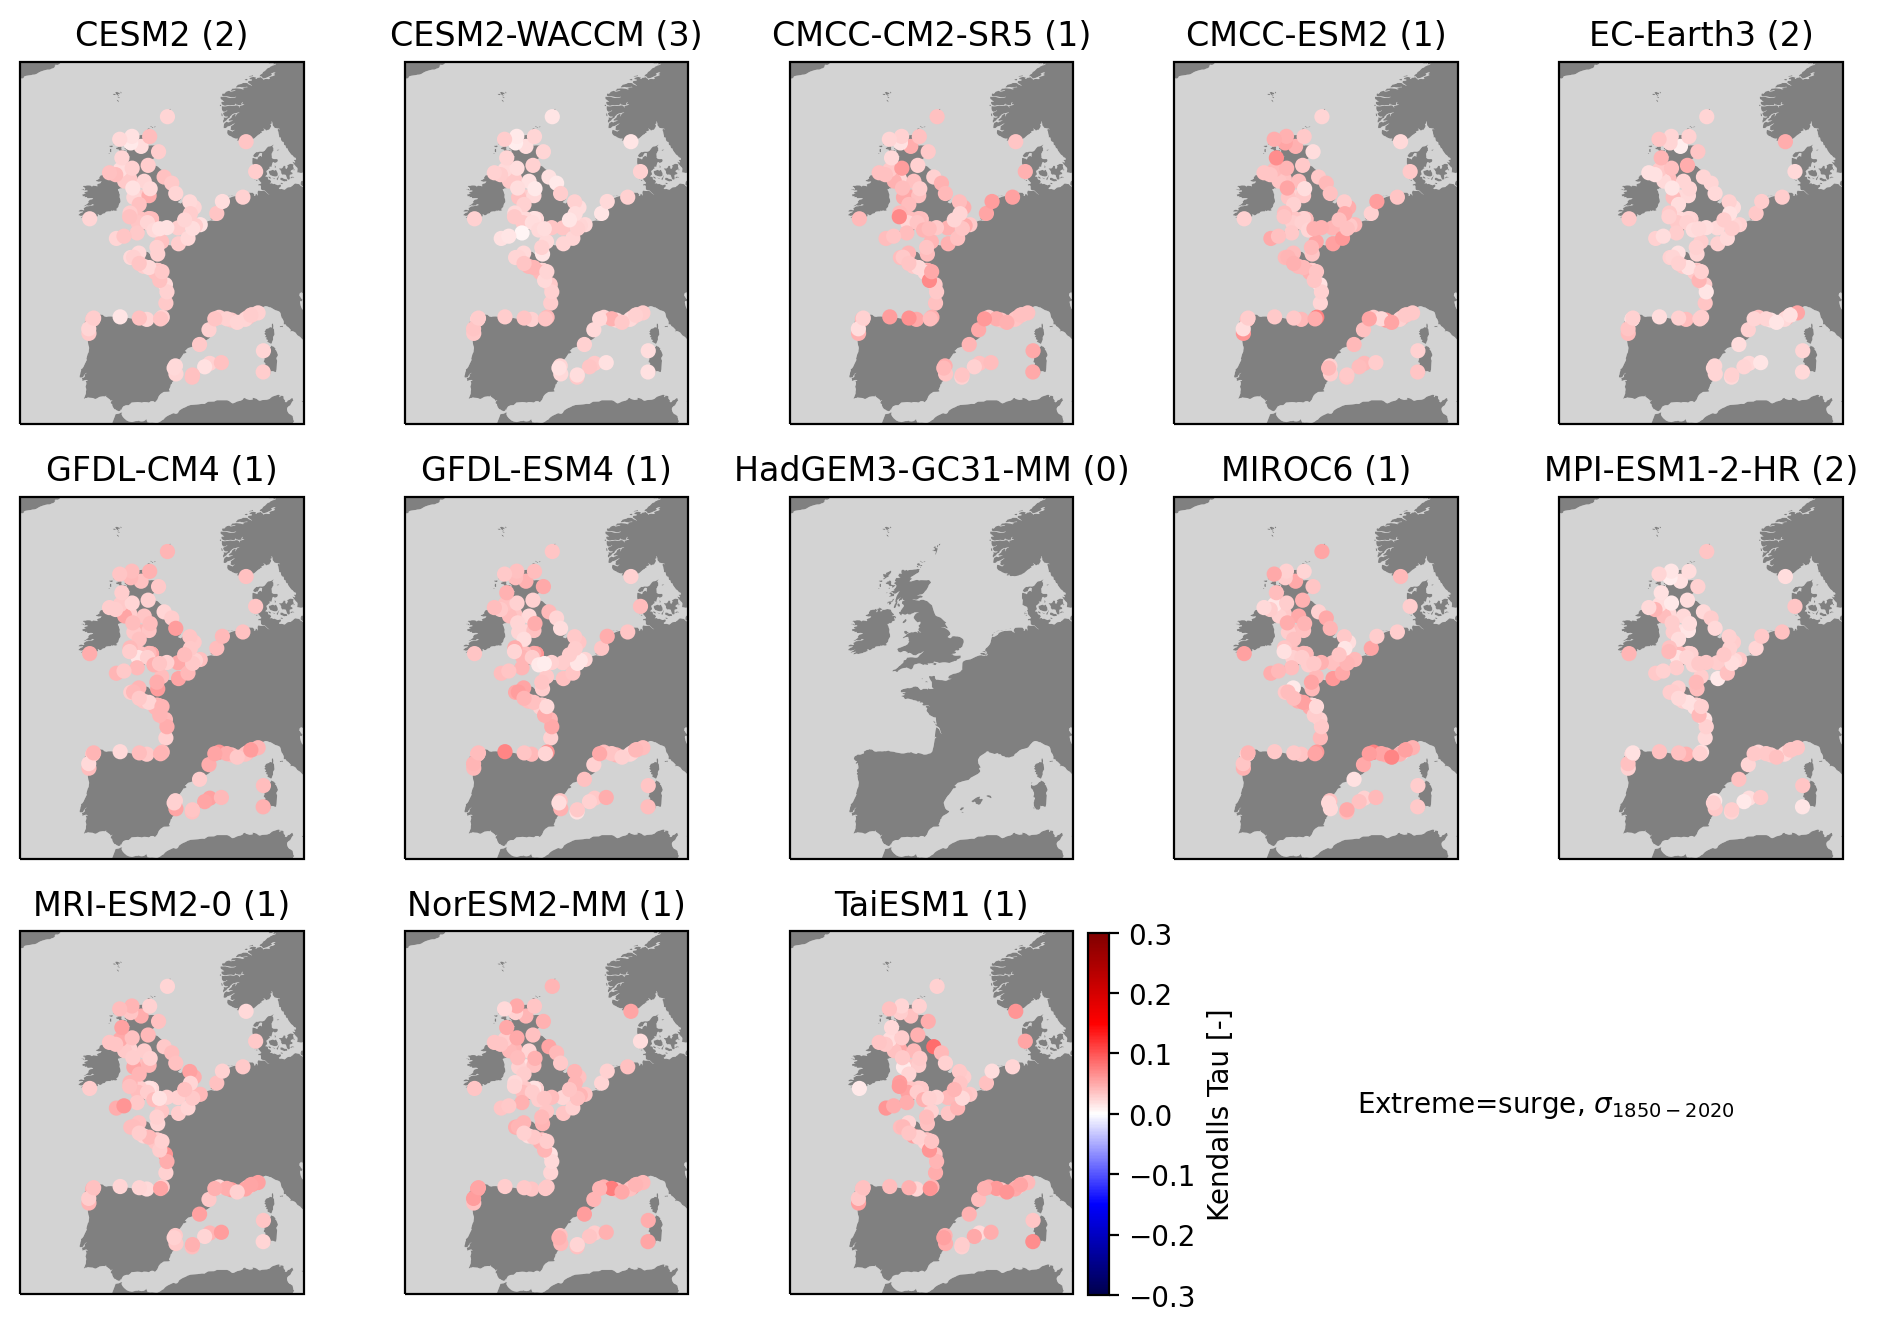

In [ ]:
for ssp in ['ssp245']:#ssps:
    ssp_ds = ds_intersect.sel(ssp=ssp)

    ssp_ds_present = ssp_ds.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    fig=plt.figure(figsize=(12,8)) #generate figure  
    gs = fig.add_gridspec(3,5)

    for m,model in enumerate(ssp_ds.source_id.values):
        #1991-2020
        ax = plt.subplot(gs[np.unravel_index(m,(3,5))],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=ssp_ds_present.ktau.sel(source_id=model).sel(statistic='coef',extreme_variate='surge').mean(dim='member_id'),cmap='seismic',vmin=-.3,vmax=.3,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
        n_members = np.isfinite(ssp_ds_present.ktau.sel(source_id=model).isel(tg=0,extreme_variate=0,statistic=0)).sum(dim='member_id').values
        ax.set_title(model +' ('+str(n_members)+')')
        if m==len(ssp_ds.source_id.values)-1:
            cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
            cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='Kendalls Tau [-]')
            ax.annotate('Extreme=surge, 1991-2020',(2,.5),xycoords='axes fraction')
        

Using all data in each ssp (less easy to compare between scenarios)

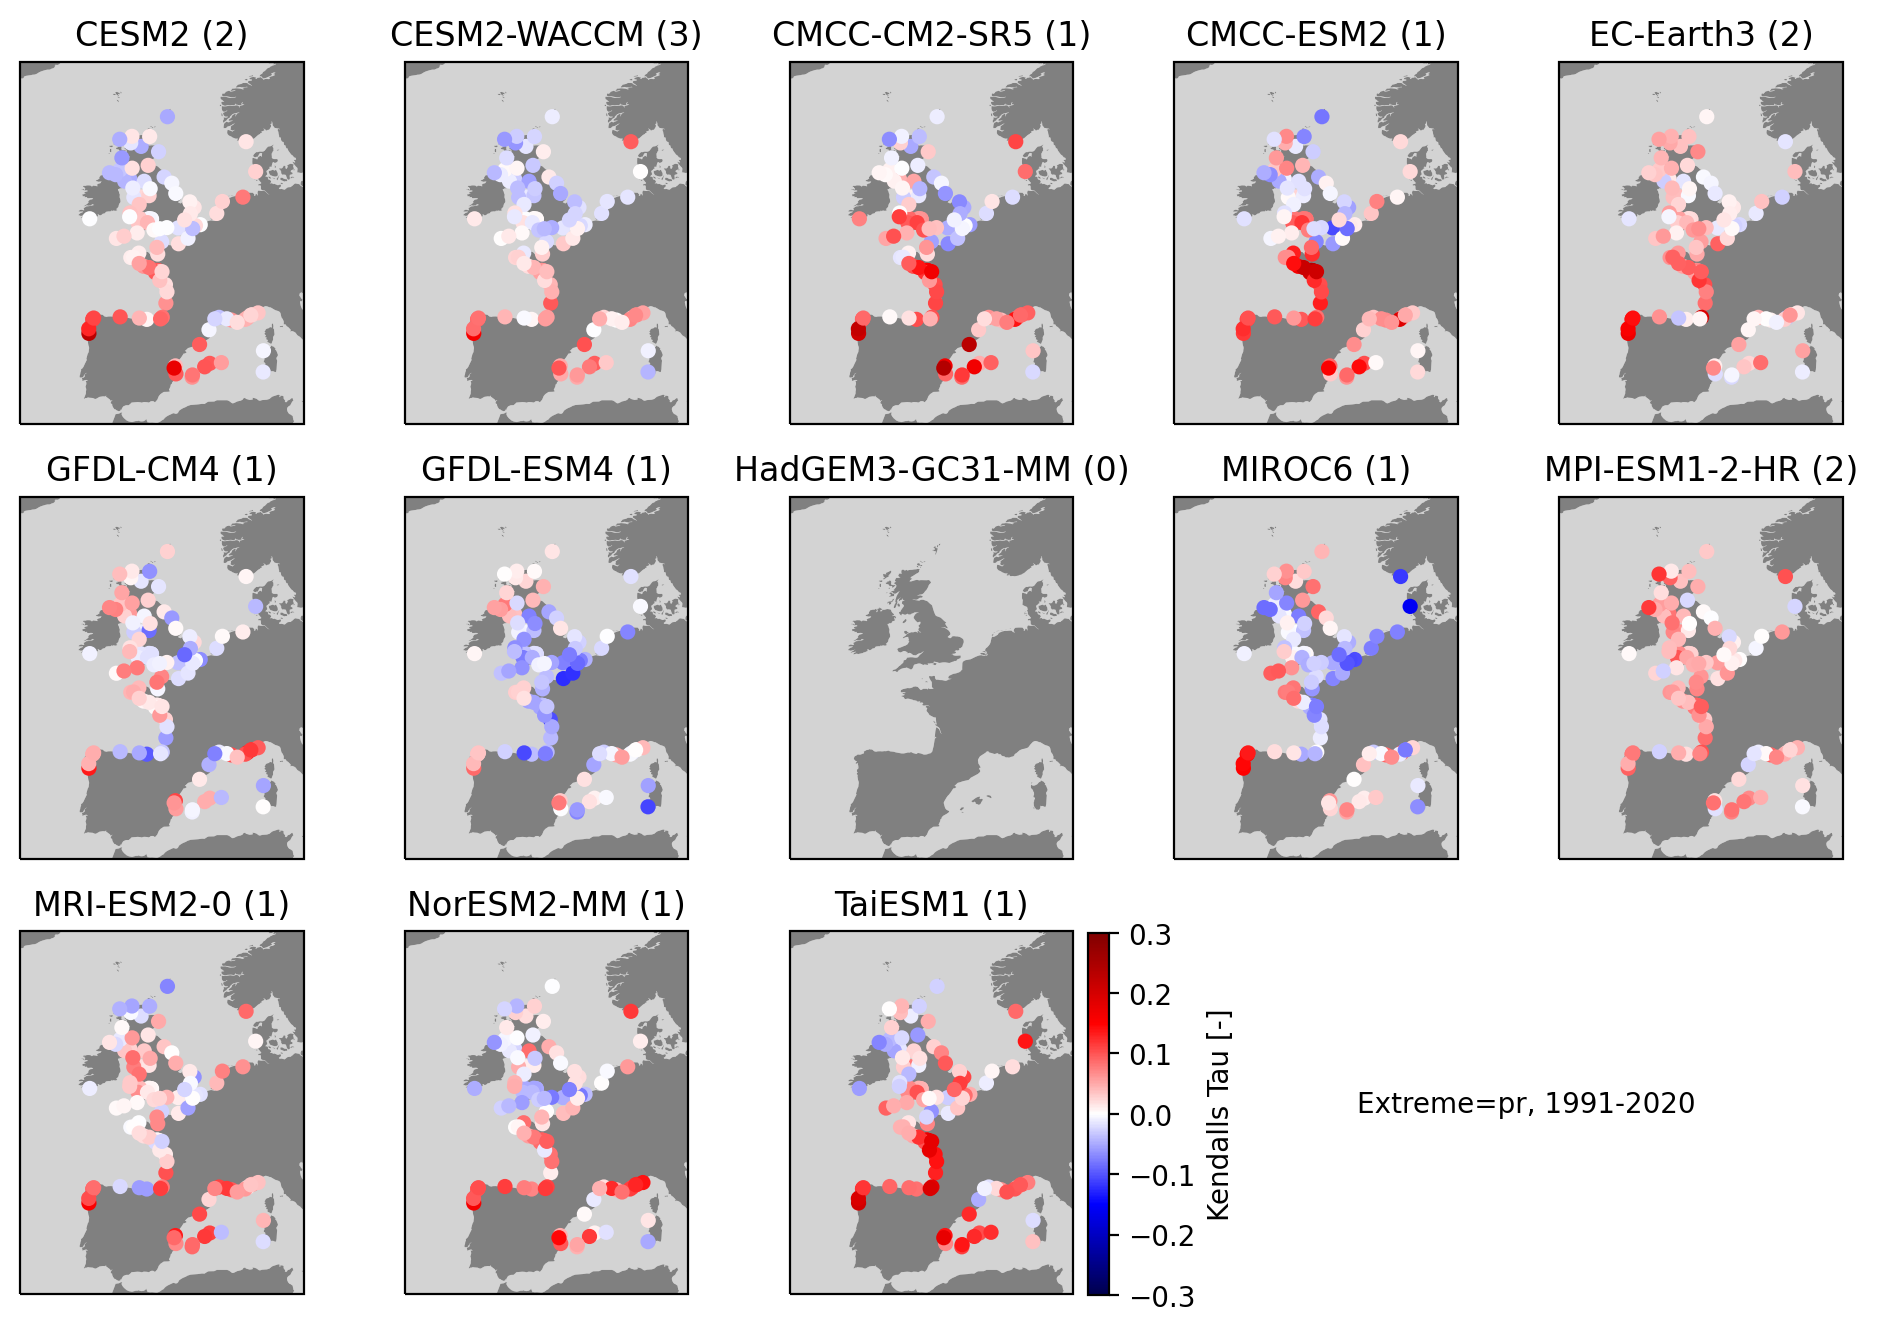

In [34]:
for ssp in ['ssp245']:#ssps:
    ssp_ds = ds_intersect.sel(ssp=ssp)

    ssp_ds_present = ssp_ds.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    fig=plt.figure(figsize=(12,8)) #generate figure  
    gs = fig.add_gridspec(3,5)

    for m,model in enumerate(ssp_ds.source_id.values):
        #1991-2020
        ax = plt.subplot(gs[np.unravel_index(m,(3,5))],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=ssp_ds_present.ktau.sel(source_id=model).sel(statistic='coef',extreme_variate='pr').mean(dim='member_id'),cmap='seismic',vmin=-.3,vmax=.3,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
        n_members = np.isfinite(ssp_ds_present.ktau.sel(source_id=model).isel(tg=0,extreme_variate=0,statistic=0)).sum(dim='member_id').values
        ax.set_title(model +' ('+str(n_members)+')')
        if m==len(ssp_ds.source_id.values)-1:
            cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
            cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='Kendalls Tau [-]')
            ax.annotate('Extreme=pr, 1991-2020',(2,.5),xycoords='axes fraction')
        

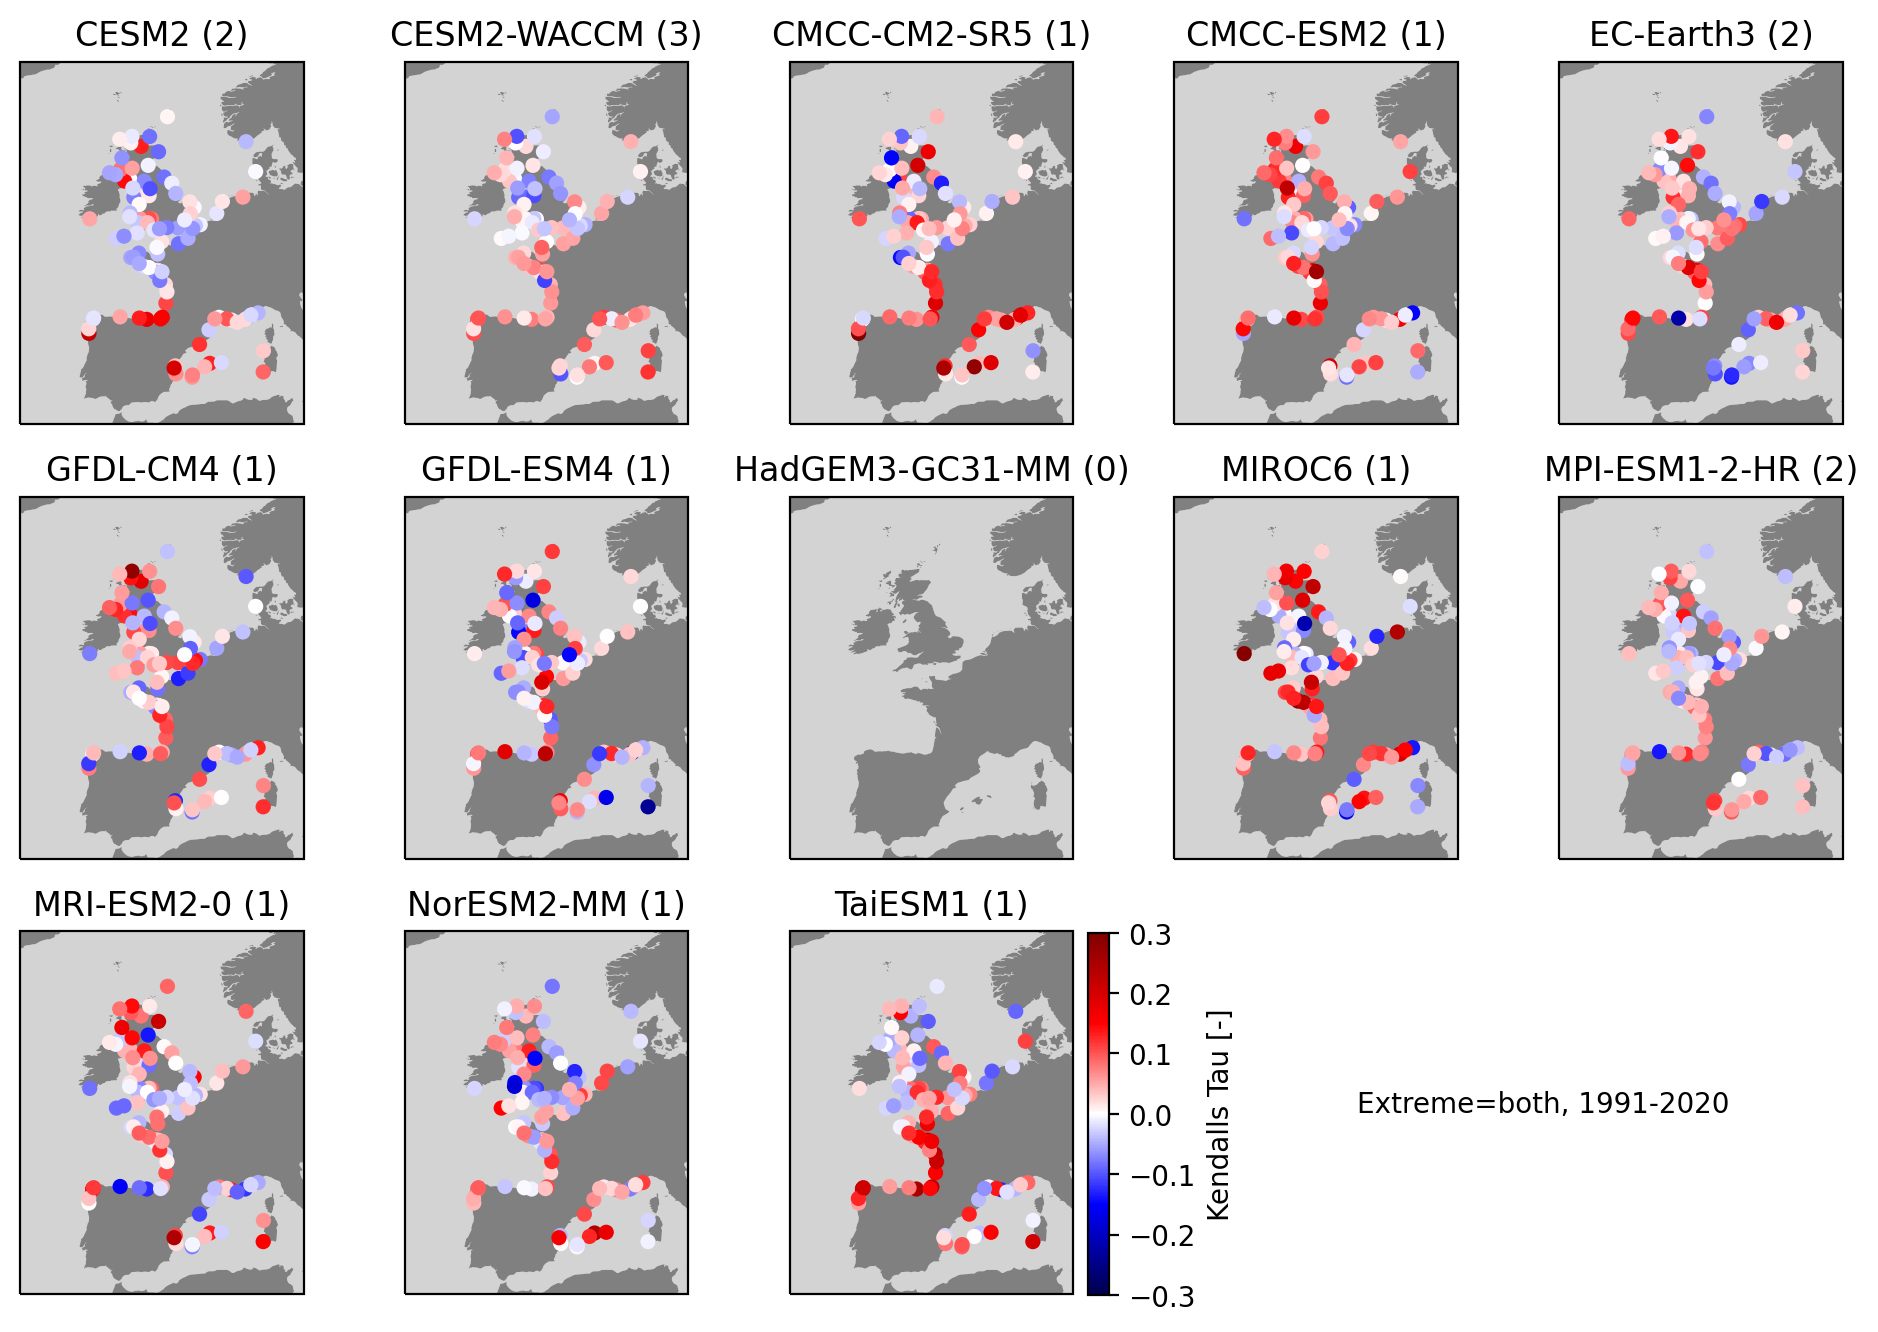

In [35]:
for ssp in ['ssp245']:#ssps:
    ssp_ds = ds_intersect.sel(ssp=ssp)

    ssp_ds_present = ssp_ds.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    fig=plt.figure(figsize=(12,8)) #generate figure  
    gs = fig.add_gridspec(3,5)

    for m,model in enumerate(ssp_ds.source_id.values):
        #1991-2020
        ax = plt.subplot(gs[np.unravel_index(m,(3,5))],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=ssp_ds_present.ktau.sel(source_id=model).sel(statistic='coef',extreme_variate='both').mean(dim='member_id'),cmap='seismic',vmin=-.3,vmax=.3,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
        n_members = np.isfinite(ssp_ds_present.ktau.sel(source_id=model).isel(tg=0,extreme_variate=0,statistic=0)).sum(dim='member_id').values
        ax.set_title(model +' ('+str(n_members)+')')
        if m==len(ssp_ds.source_id.values)-1:
            cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
            cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='Kendalls Tau [-]')
            ax.annotate('Extreme=both, 1991-2020',(2,.5),xycoords='axes fraction')
        

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/array/numpy_compat.py:42: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/srv

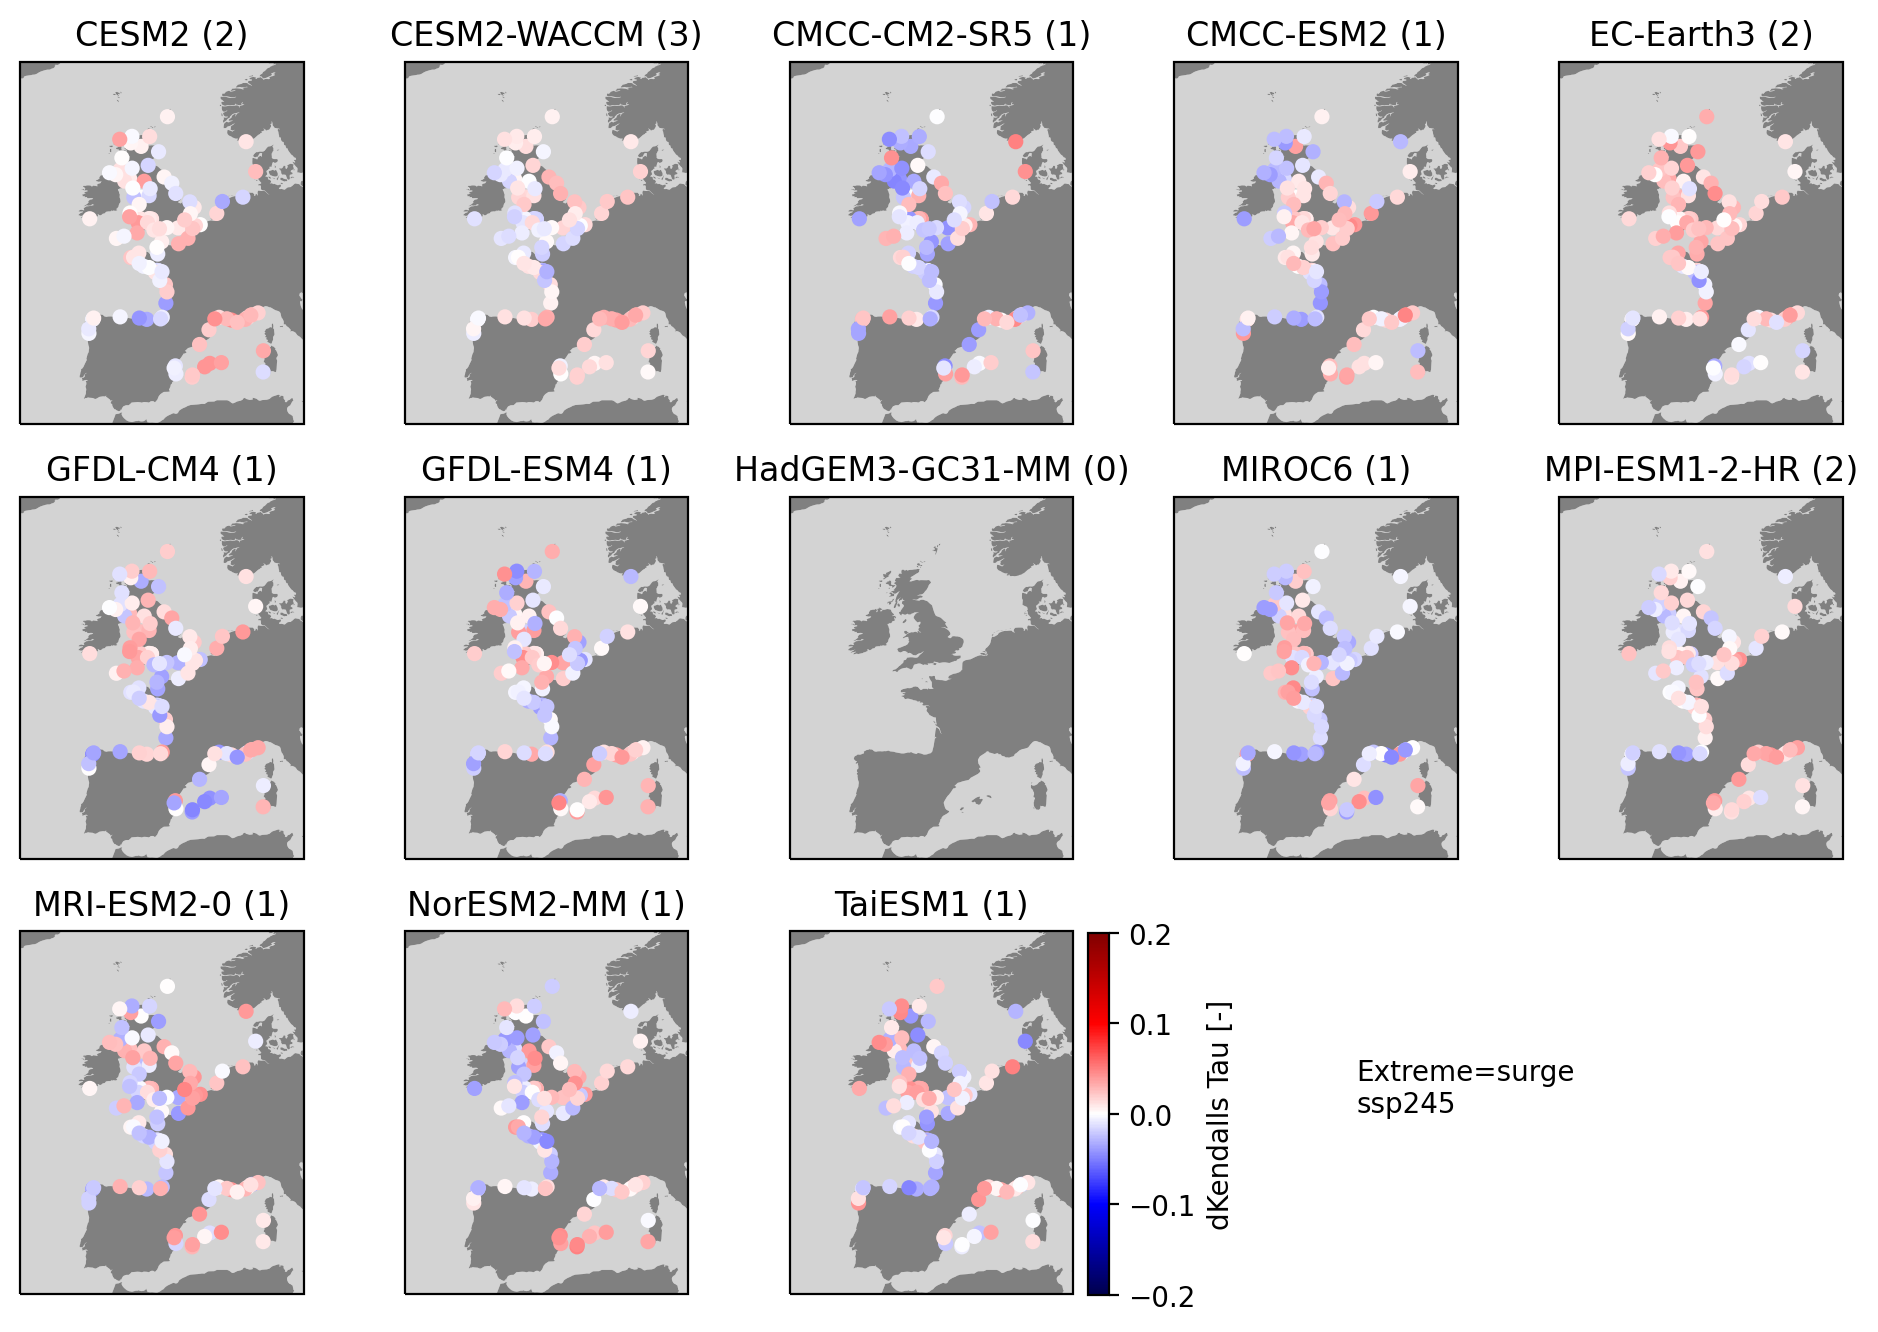

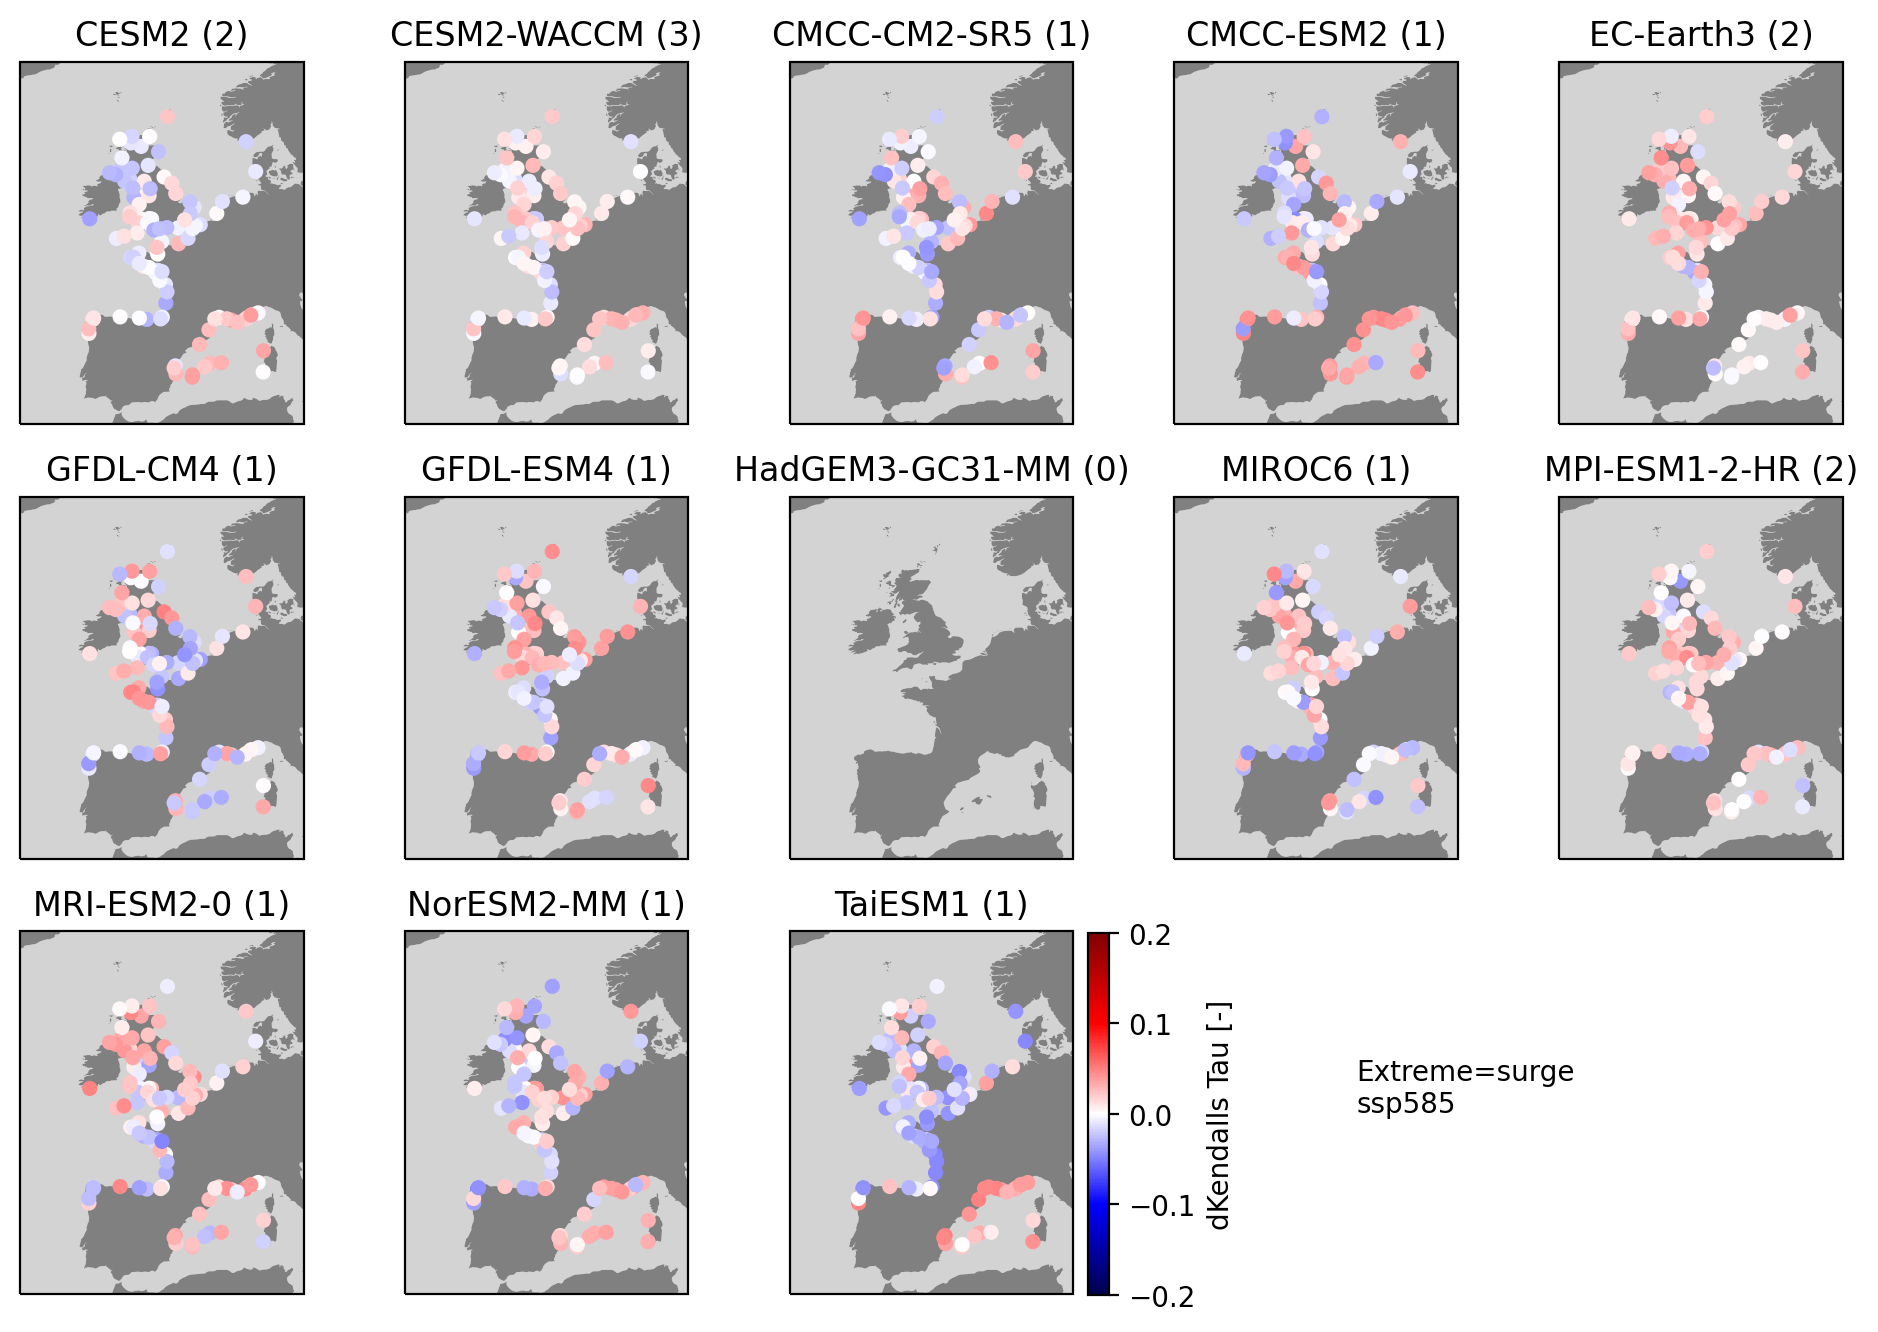

In [8]:
for ssp in ssps:
    ssp_ds = ds_intersect.sel(ssp=ssp)

    ssp_ds_present = ssp_ds.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    fig=plt.figure(figsize=(12,8)) #generate figure  
    gs = fig.add_gridspec(3,5)

    for m,model in enumerate(ssp_ds.source_id.values):
        #1991-2020
        ax = plt.subplot(gs[np.unravel_index(m,(3,5))],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=(1/20)*ssp_ds['ktau_slope'].sel(source_id=model).sel(statistic='coef',extreme_variate='surge').mean(dim='member_id'),cmap='seismic',vmin=-.2,vmax=.2,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
        n_members = np.isfinite(ssp_ds_present.ktau.sel(source_id=model).isel(tg=0,extreme_variate=0,statistic=0)).sum(dim='member_id').values
        ax.set_title(model +' ('+str(n_members)+')')
        if m==len(ssp_ds.source_id.values)-1:
            cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
            cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='dKendalls Tau [-]')
            ax.annotate('Extreme=surge\n'+ssp,(2,.5),xycoords='axes fraction')
        

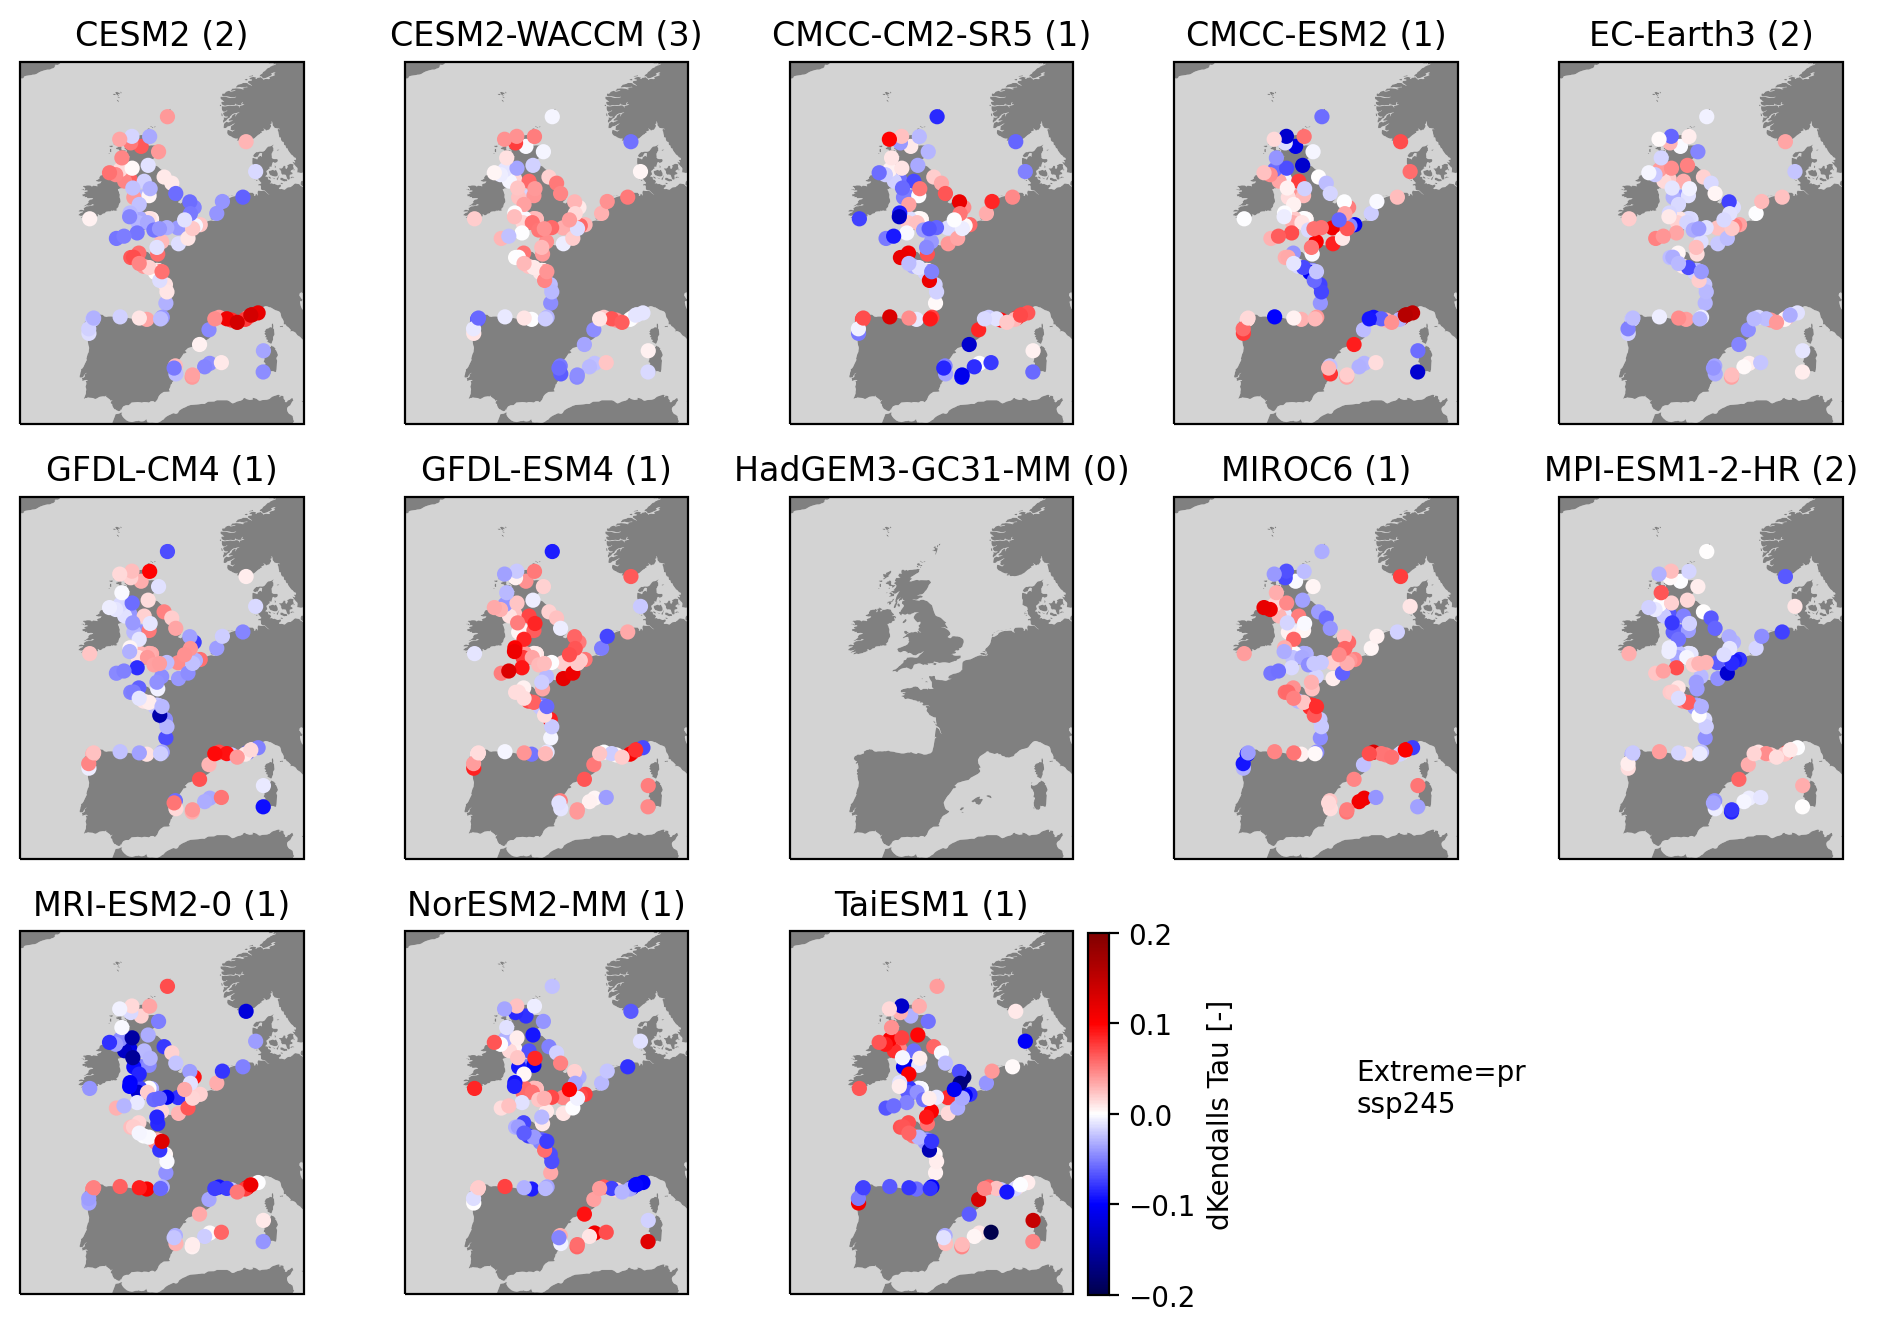

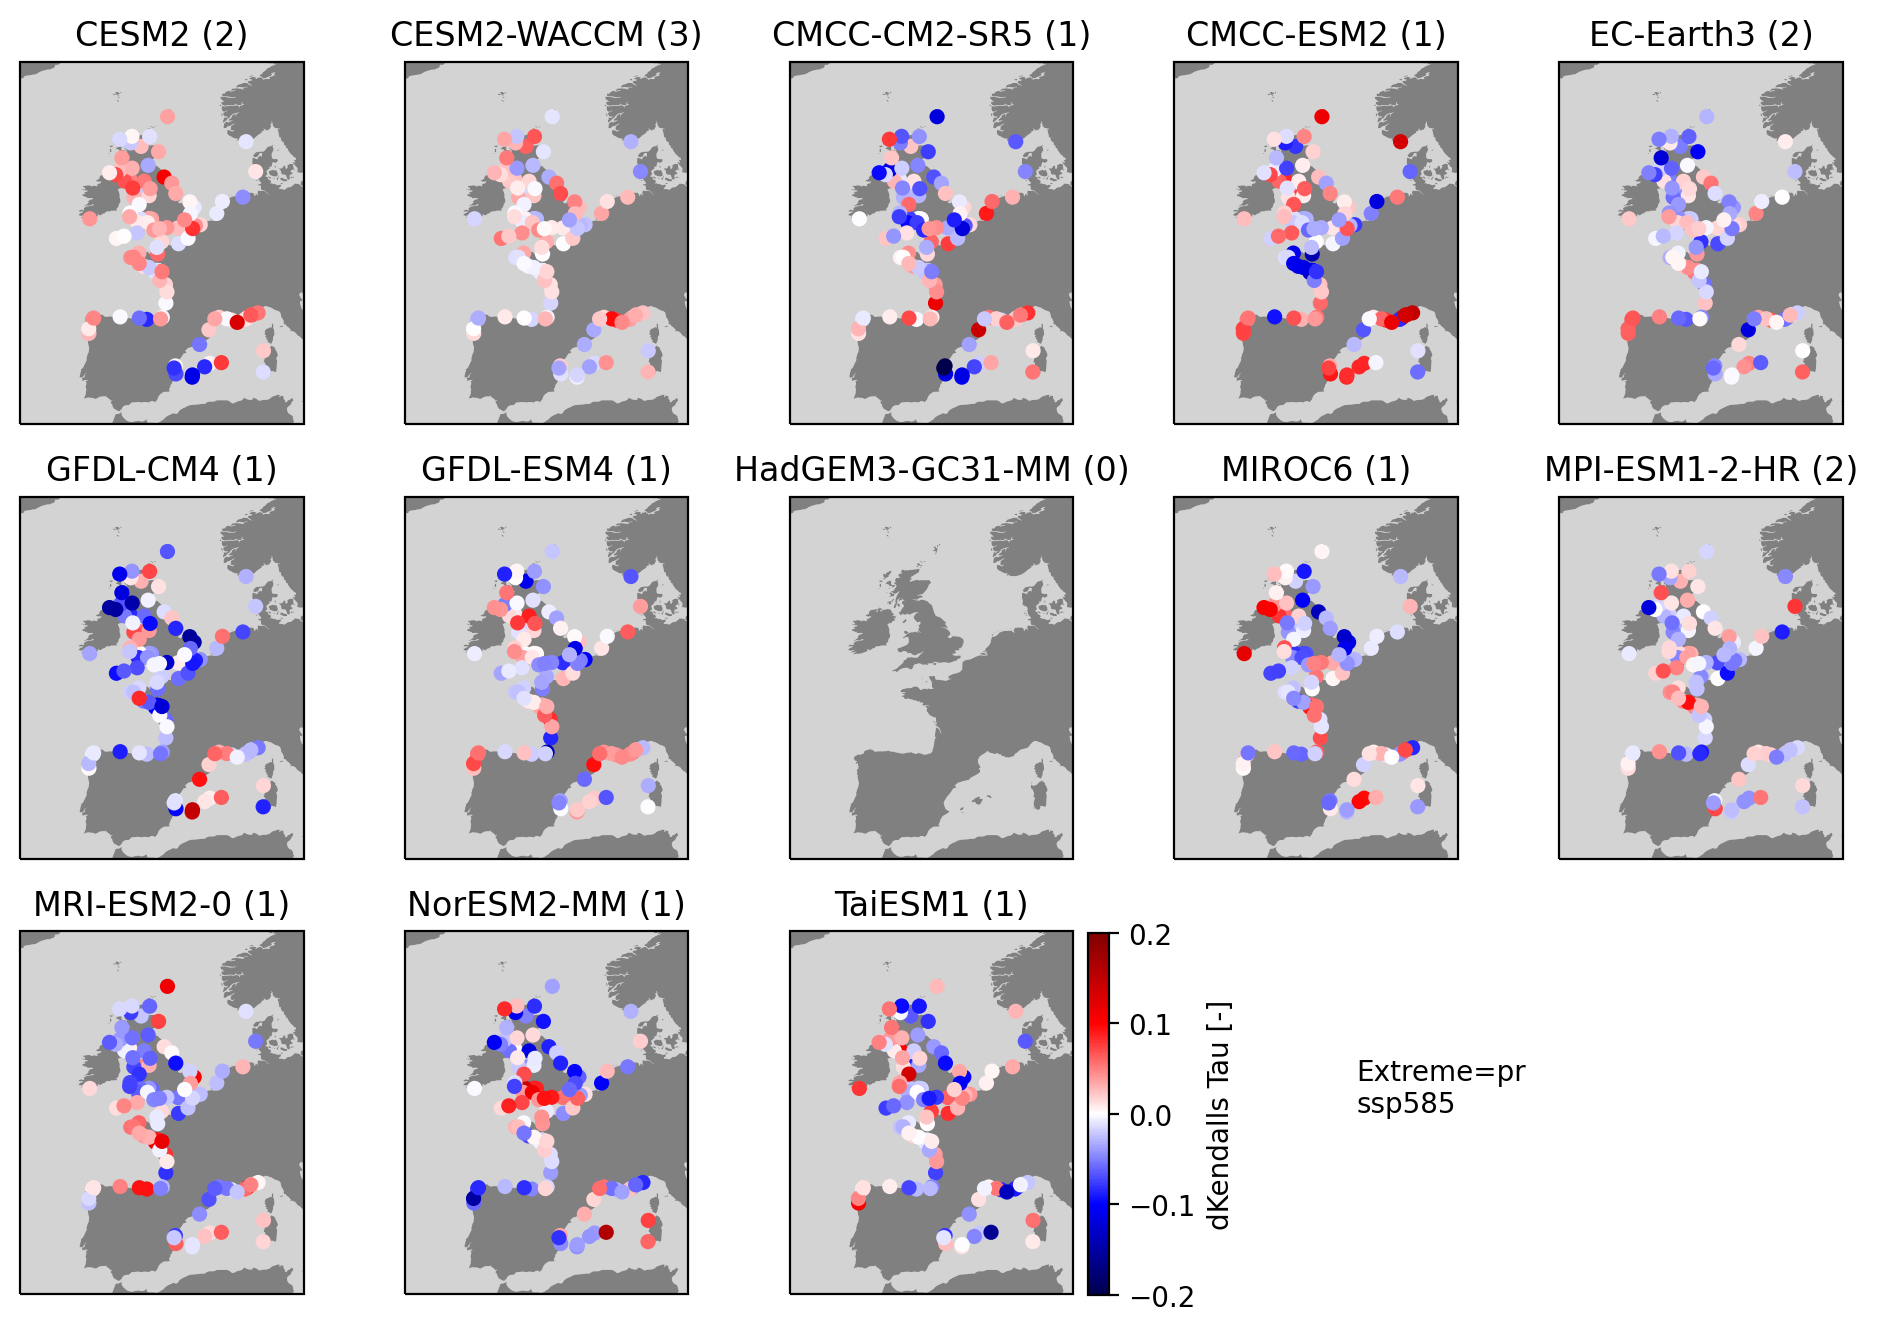

In [7]:
for ssp in ssps:
    ssp_ds = ds_intersect.sel(ssp=ssp)

    ssp_ds_present = ssp_ds.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    fig=plt.figure(figsize=(12,8)) #generate figure  
    gs = fig.add_gridspec(3,5)

    for m,model in enumerate(ssp_ds.source_id.values):
        #1991-2020
        ax = plt.subplot(gs[np.unravel_index(m,(3,5))],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=ssp_ds_diff.ktau.sel(source_id=model).sel(statistic='coef',extreme_variate='pr').mean(dim='member_id'),cmap='seismic',vmin=-.2,vmax=.2,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
        n_members = np.isfinite(ssp_ds_present.ktau.sel(source_id=model).isel(tg=0,extreme_variate=0,statistic=0)).sum(dim='member_id').values
        ax.set_title(model +' ('+str(n_members)+')')
        if m==len(ssp_ds.source_id.values)-1:
            cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
            cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='dKendalls Tau [-]')
            ax.annotate('Extreme=pr\n'+ssp,(2,.5),xycoords='axes fraction')
        

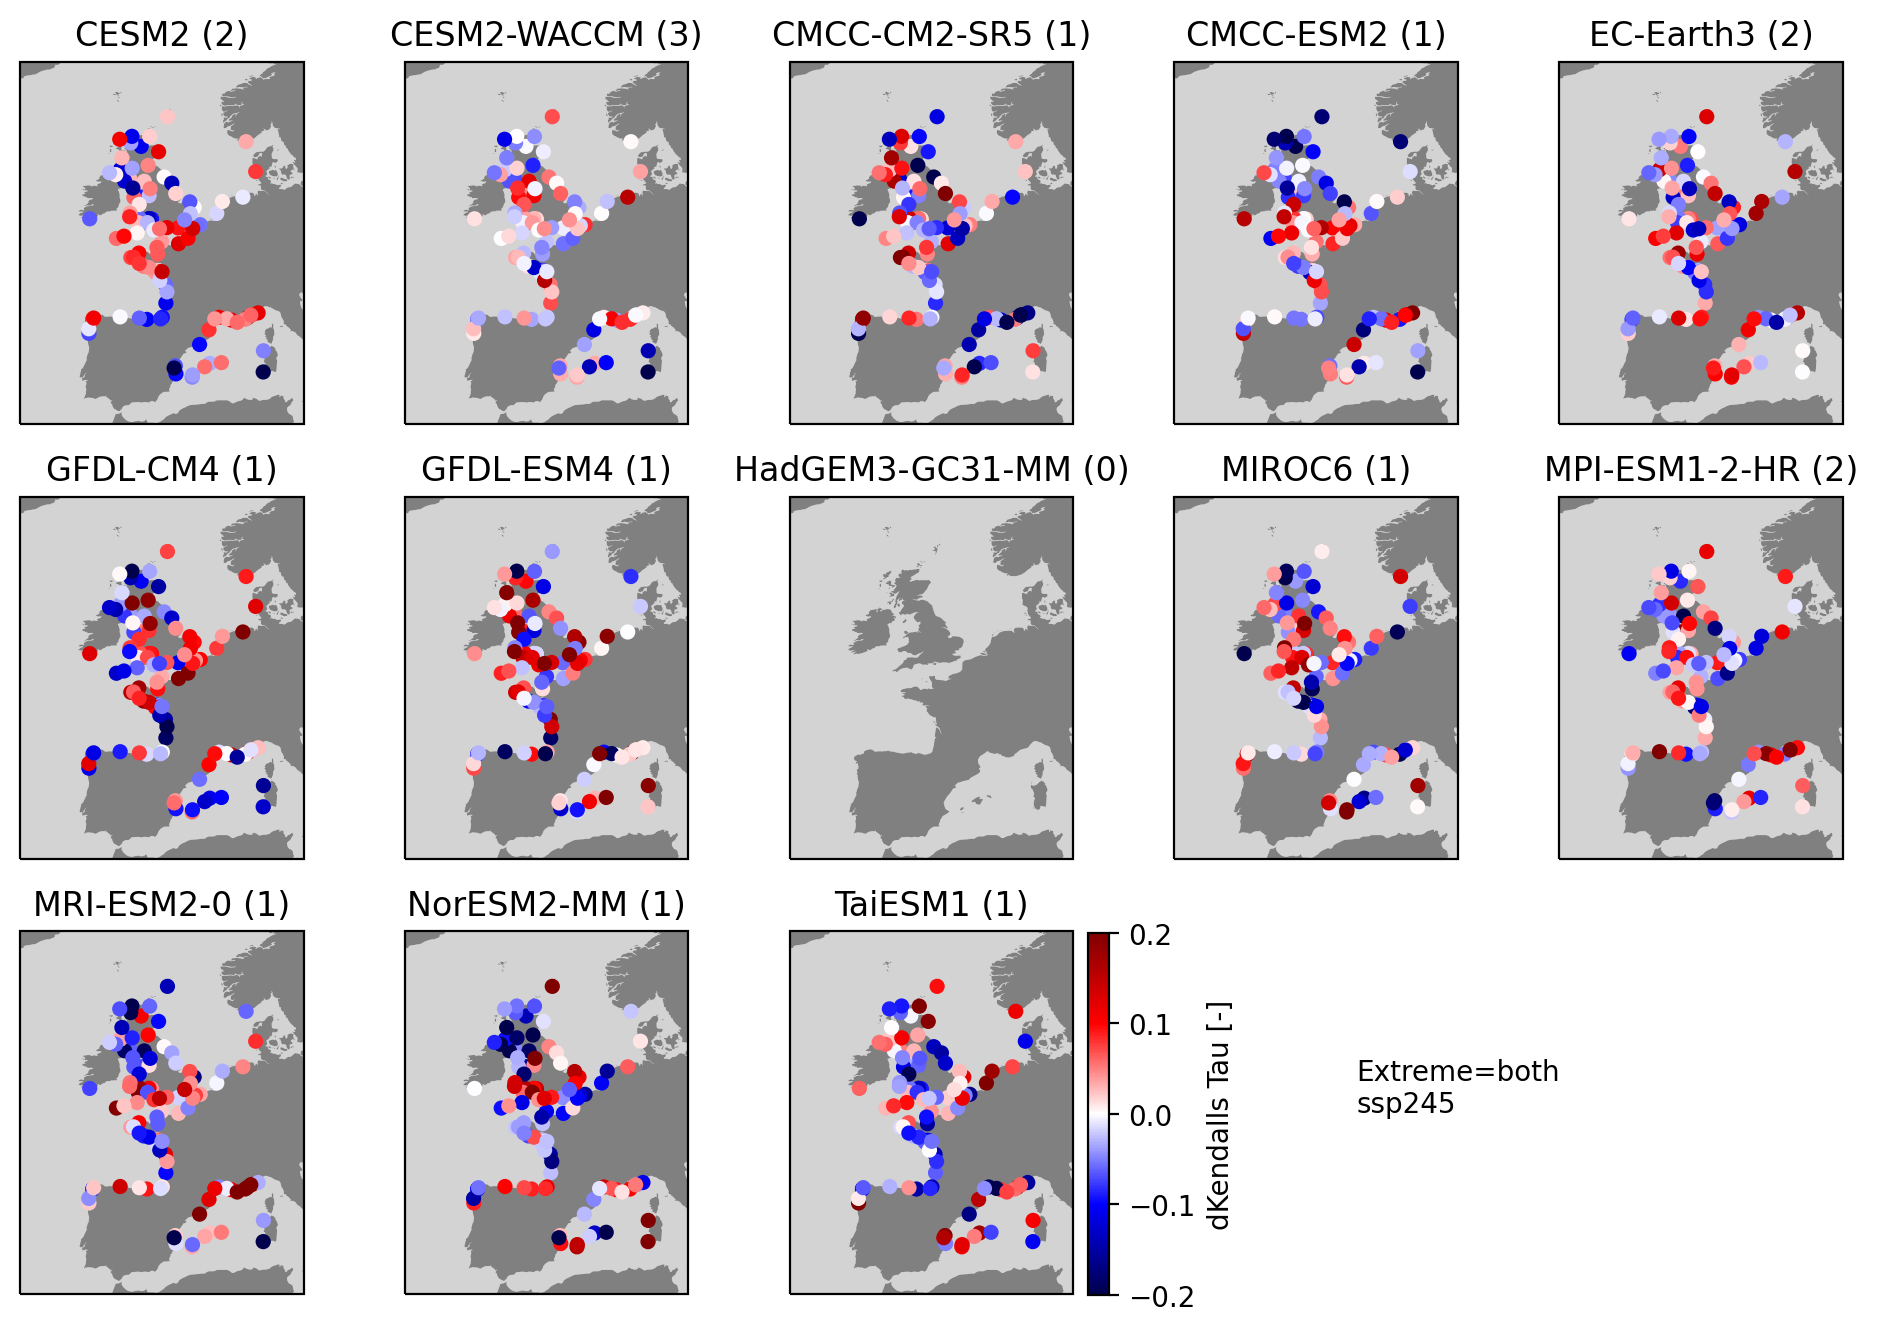

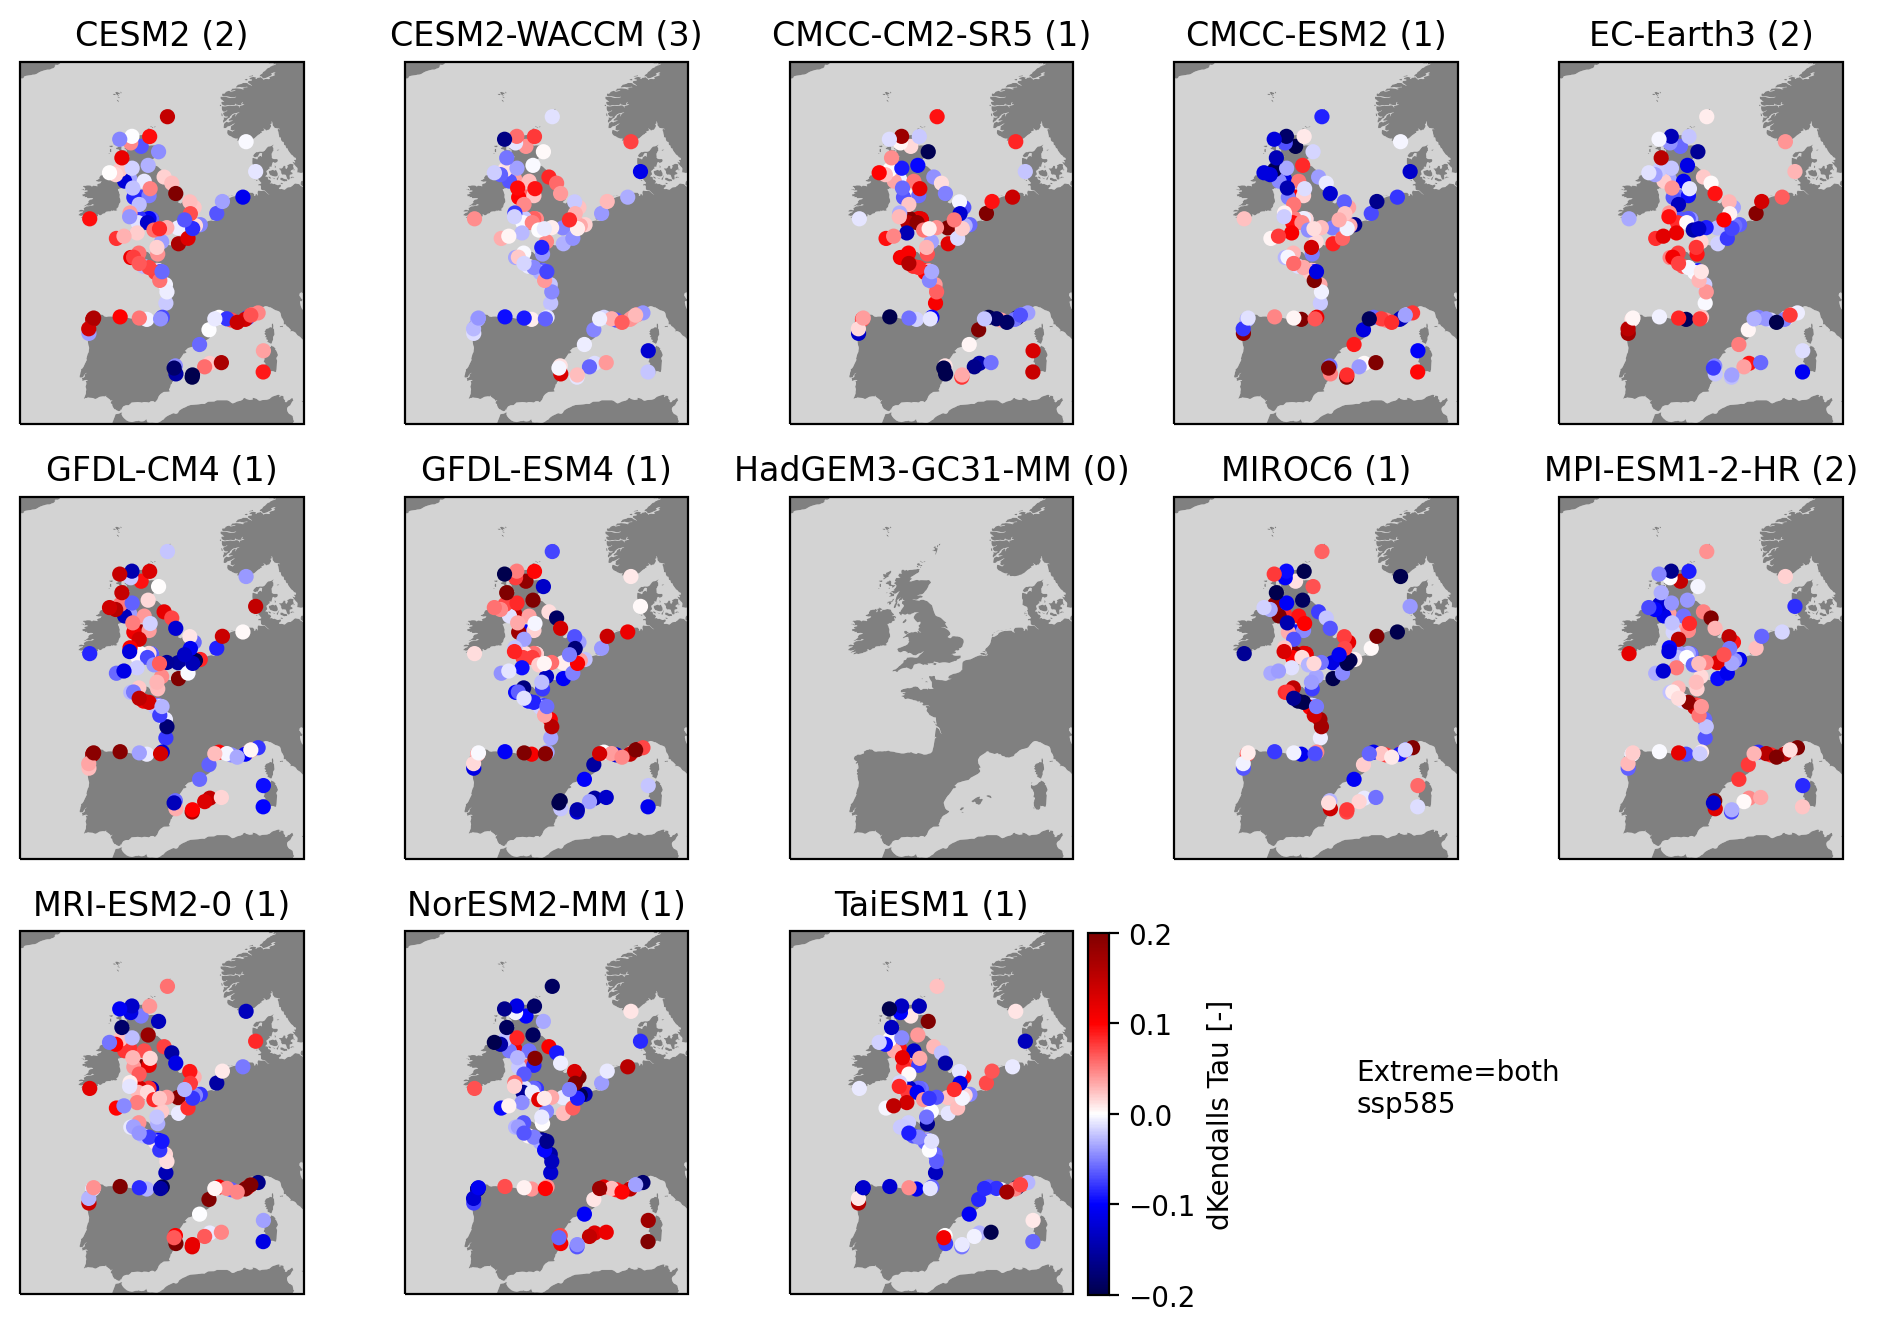

In [8]:
for ssp in ssps:
    ssp_ds = ds_intersect.sel(ssp=ssp)

    ssp_ds_present = ssp_ds.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    fig=plt.figure(figsize=(12,8)) #generate figure  
    gs = fig.add_gridspec(3,5)

    for m,model in enumerate(ssp_ds.source_id.values):
        #1991-2020
        ax = plt.subplot(gs[np.unravel_index(m,(3,5))],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=ssp_ds_diff.ktau.sel(source_id=model).sel(statistic='coef',extreme_variate='both').mean(dim='member_id'),cmap='seismic',vmin=-.2,vmax=.2,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
        n_members = np.isfinite(ssp_ds_present.ktau.sel(source_id=model).isel(tg=0,extreme_variate=0,statistic=0)).sum(dim='member_id').values
        ax.set_title(model +' ('+str(n_members)+')')
        if m==len(ssp_ds.source_id.values)-1:
            cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
            cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='dKendalls Tau [-]')
            ax.annotate('Extreme=both\n'+ssp,(2,.5),xycoords='axes fraction')

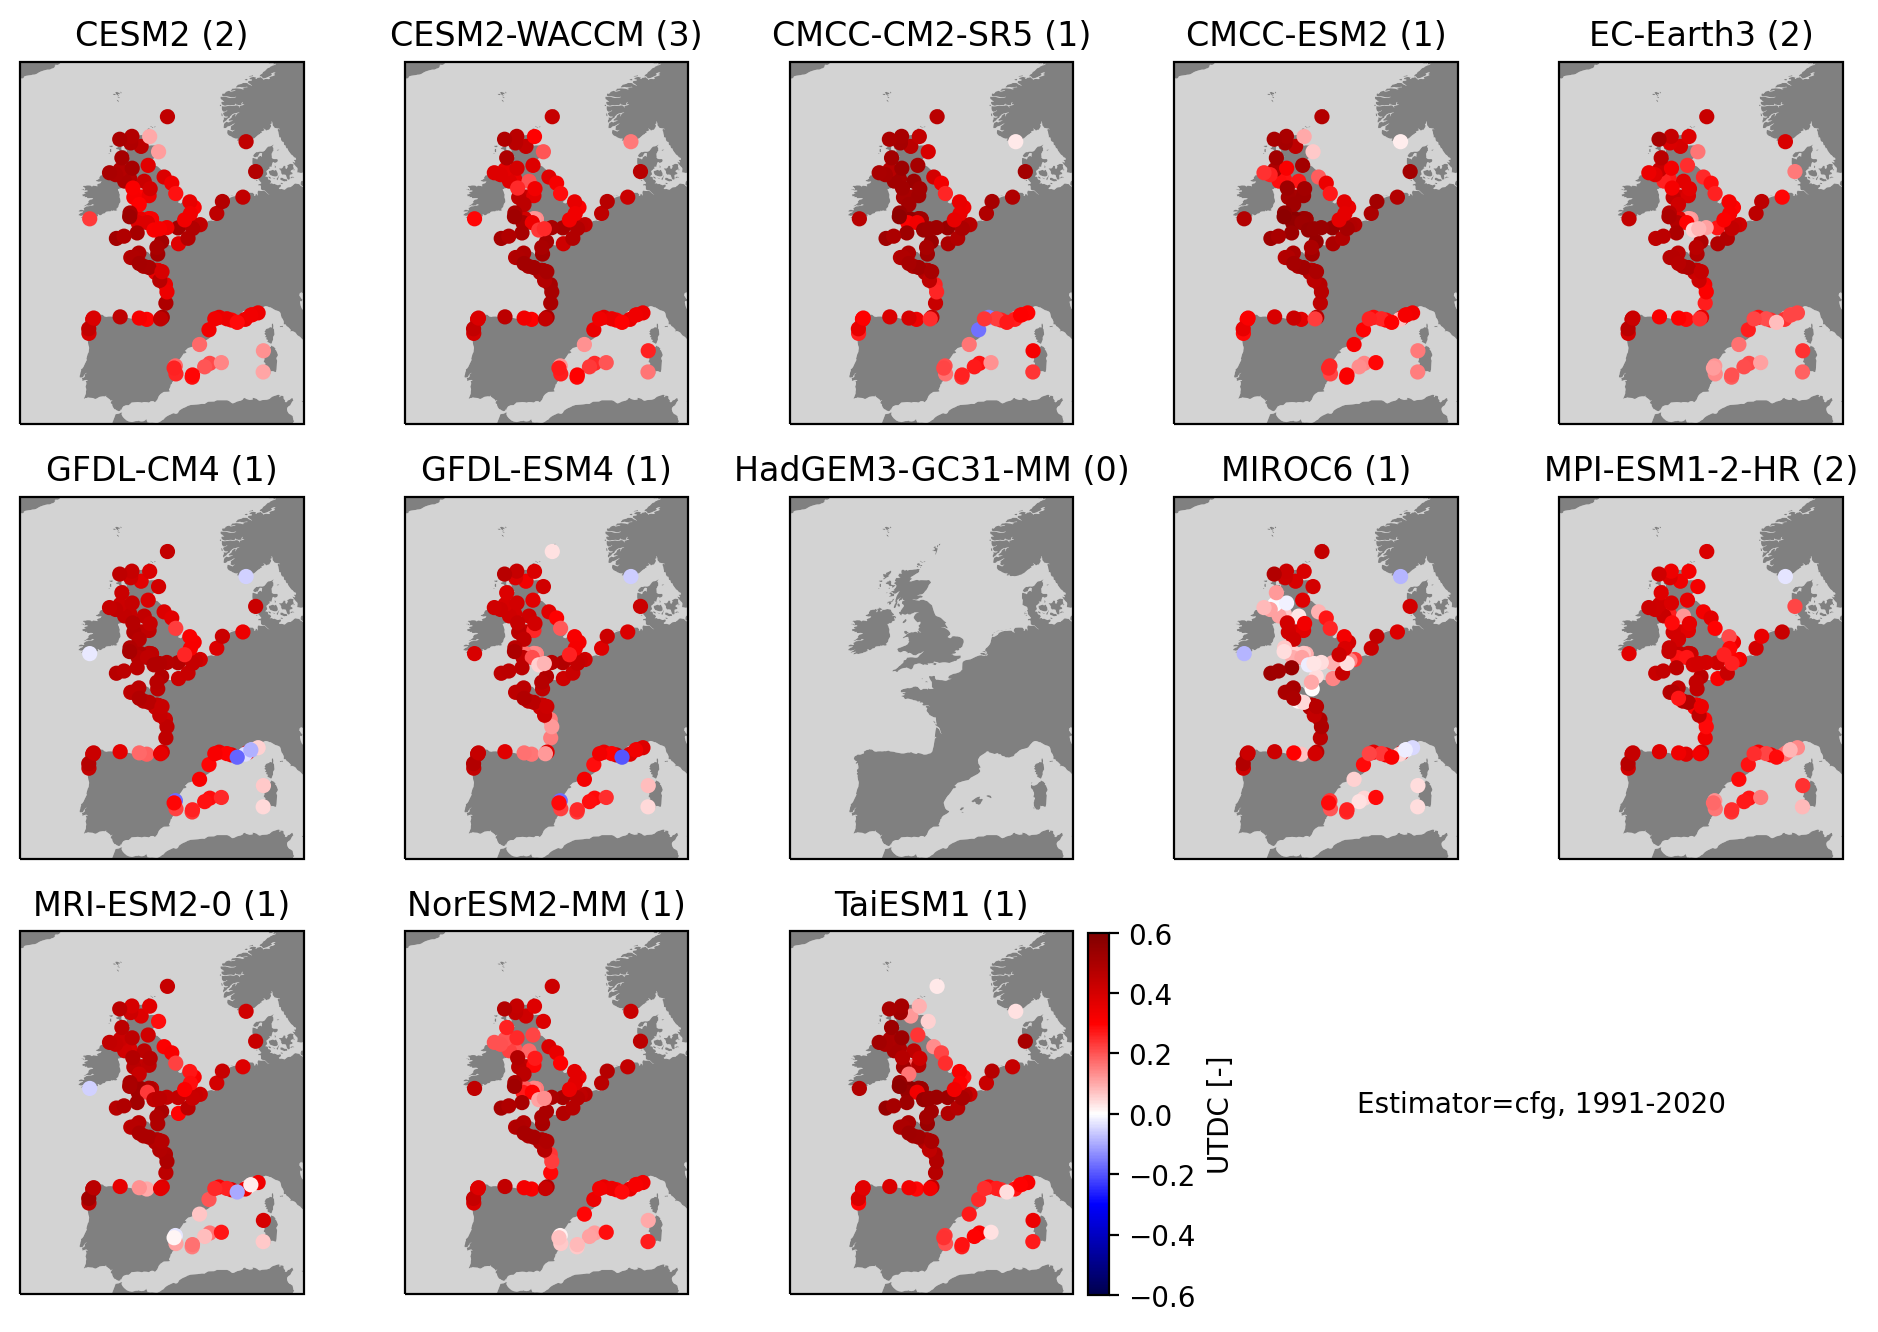

In [10]:
for ssp in ['ssp245']:#ssps:
    ssp_ds = ds_intersect.sel(ssp=ssp)

    ssp_ds_present = ssp_ds.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    fig=plt.figure(figsize=(12,8)) #generate figure  
    gs = fig.add_gridspec(3,5)

    for m,model in enumerate(ssp_ds.source_id.values):
        #1991-2020
        ax = plt.subplot(gs[np.unravel_index(m,(3,5))],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=ssp_ds_present.utdc.sel(source_id=model).sel(statistic='coef',estimator='cfg').mean(dim='member_id'),cmap='seismic',vmin=-.6,vmax=.6,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
        n_members = np.isfinite(ssp_ds_present.utdc.sel(source_id=model).isel(tg=0,estimator=0,statistic=0)).sum(dim='member_id').values
        ax.set_title(model +' ('+str(n_members)+')')
        if m==len(ssp_ds.source_id.values)-1:
            cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
            cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='UTDC [-]')
            ax.annotate('Estimator=cfg, 1991-2020',(2,.5),xycoords='axes fraction')
        

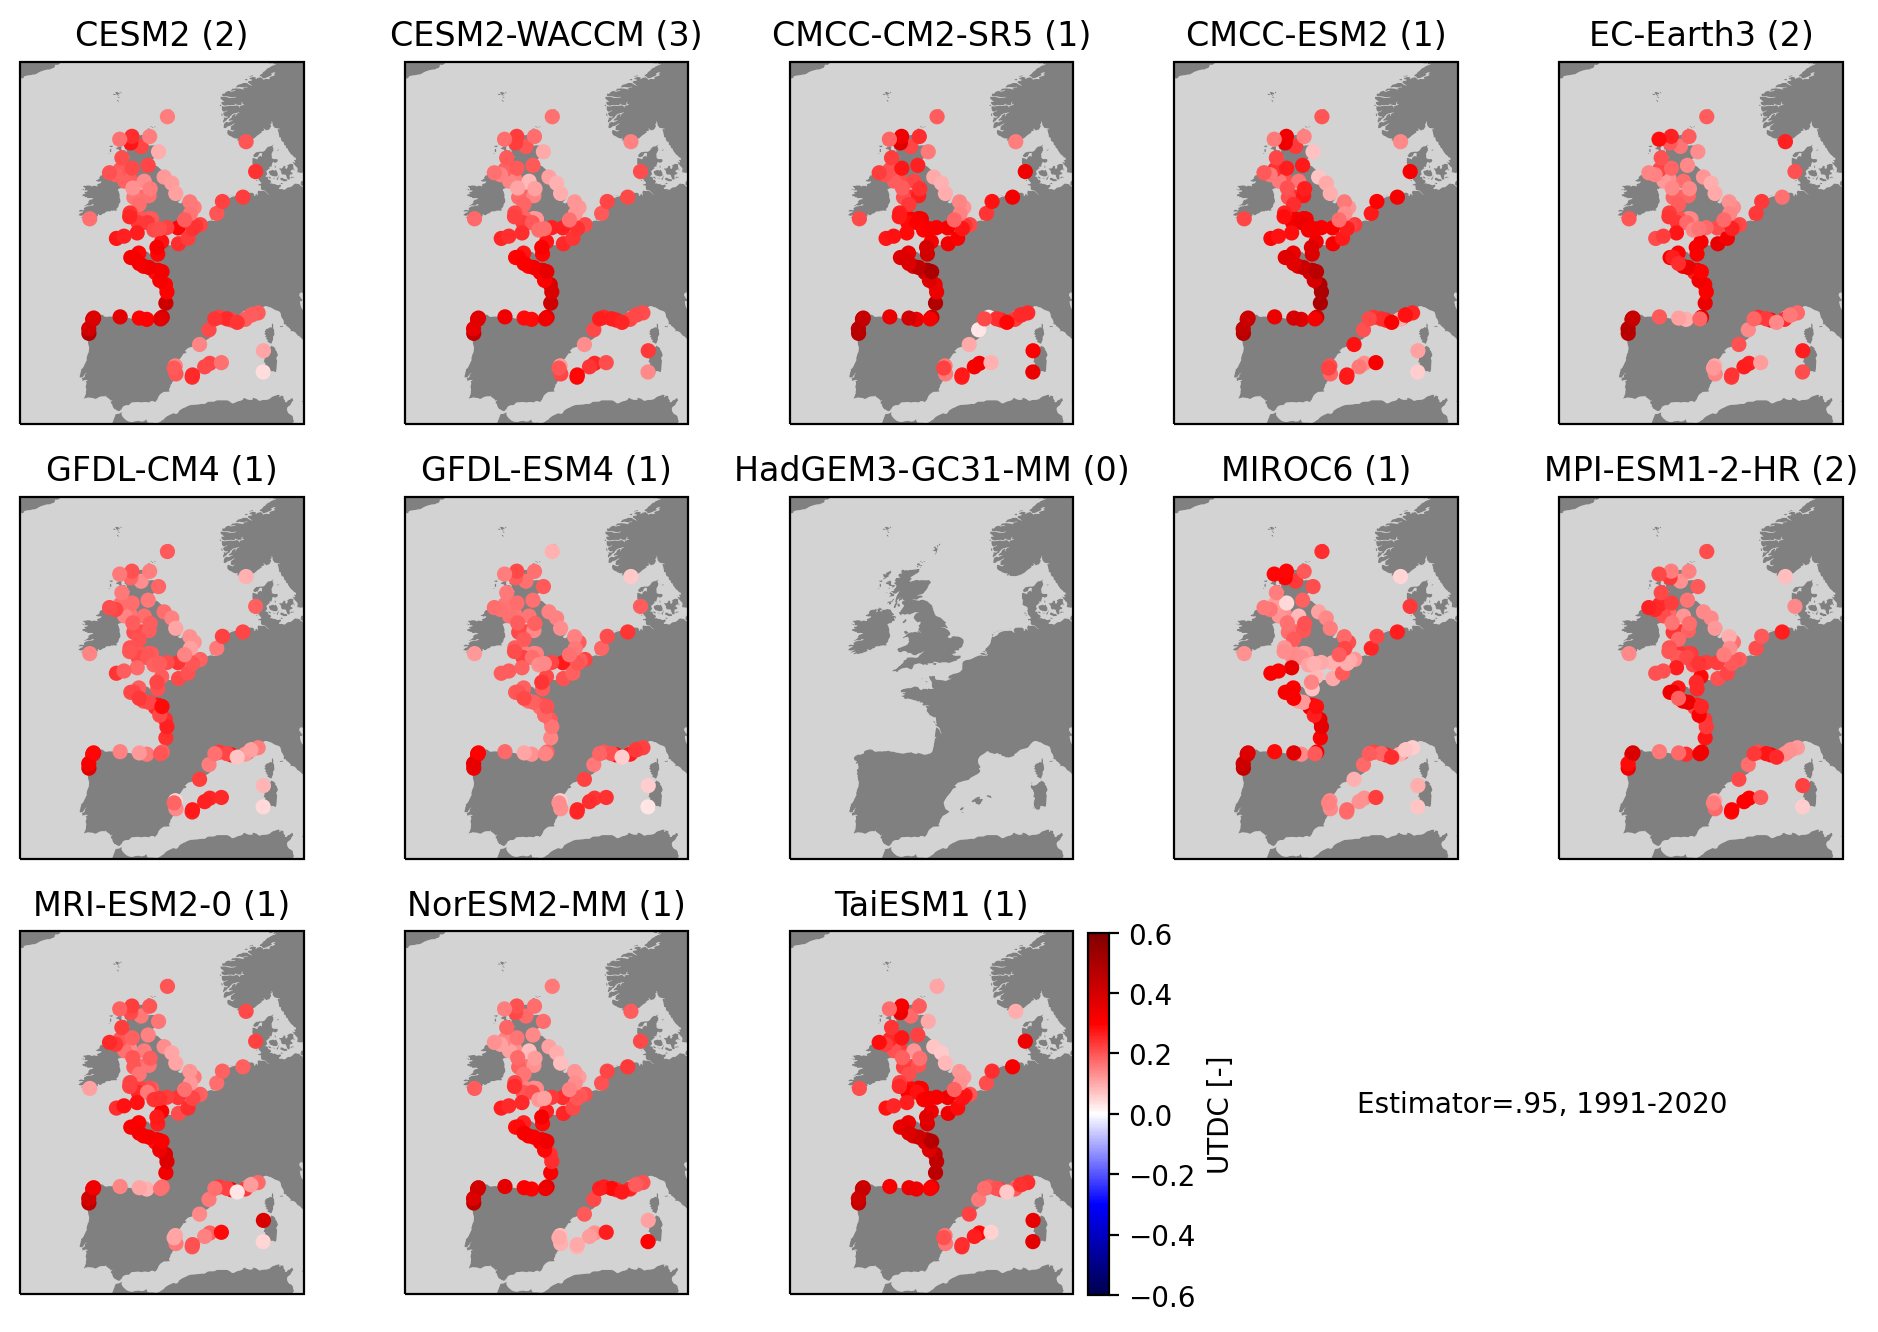

In [11]:
for ssp in ['ssp245']:#ssps:
    ssp_ds = ds_intersect.sel(ssp=ssp)

    ssp_ds_present = ssp_ds.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    fig=plt.figure(figsize=(12,8)) #generate figure  
    gs = fig.add_gridspec(3,5)

    for m,model in enumerate(ssp_ds.source_id.values):
        #1991-2020
        ax = plt.subplot(gs[np.unravel_index(m,(3,5))],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=ssp_ds_present.utdc.sel(source_id=model).sel(statistic='coef',estimator='.95').mean(dim='member_id'),cmap='seismic',vmin=-.6,vmax=.6,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
        n_members = np.isfinite(ssp_ds_present.utdc.sel(source_id=model).isel(tg=0,estimator=0,statistic=0)).sum(dim='member_id').values
        ax.set_title(model +' ('+str(n_members)+')')
        if m==len(ssp_ds.source_id.values)-1:
            cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
            cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='UTDC [-]')
            ax.annotate('Estimator=.95, 1991-2020',(2,.5),xycoords='axes fraction')
        

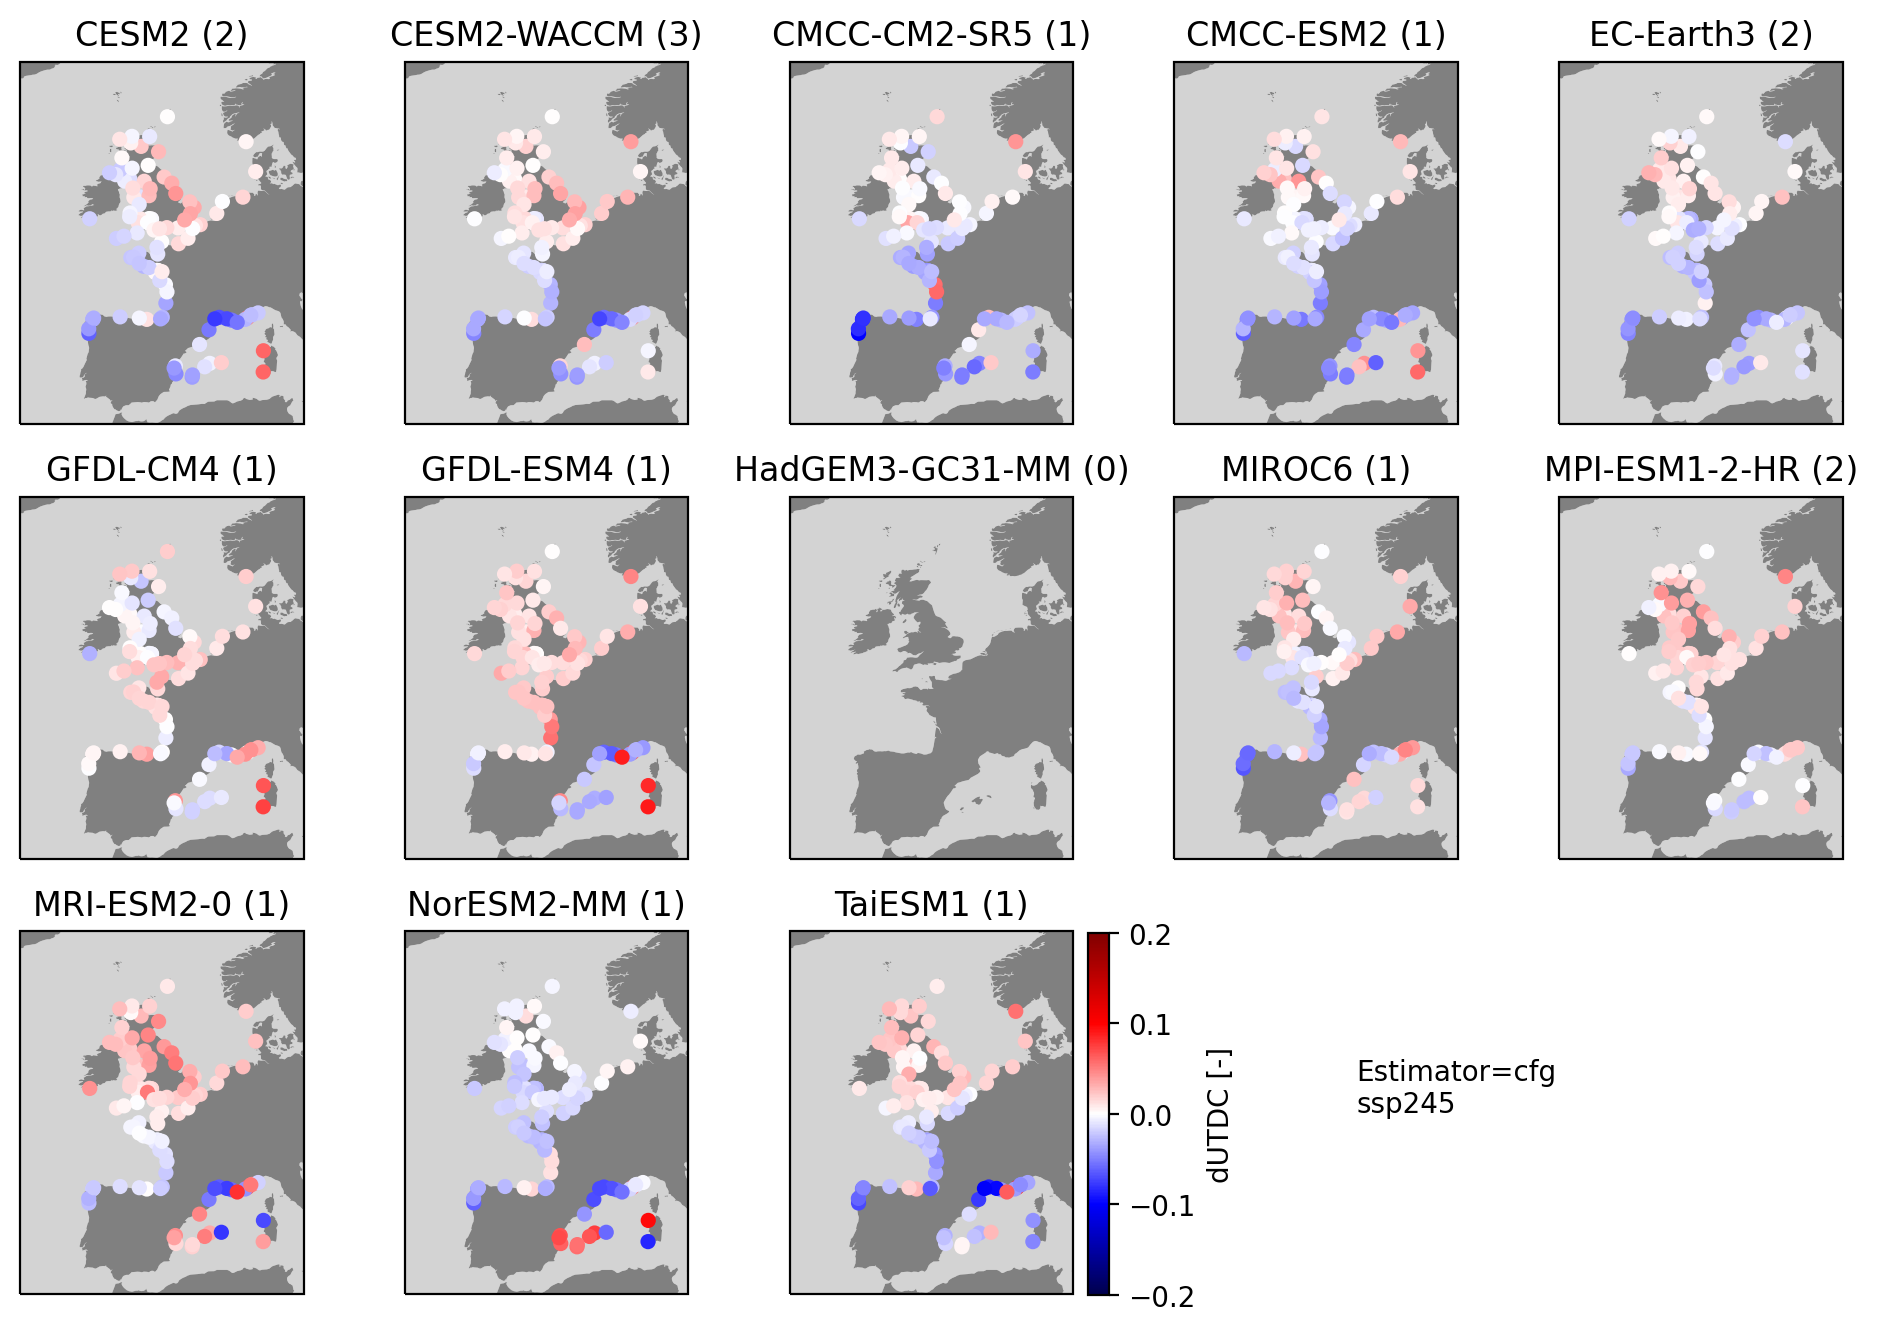

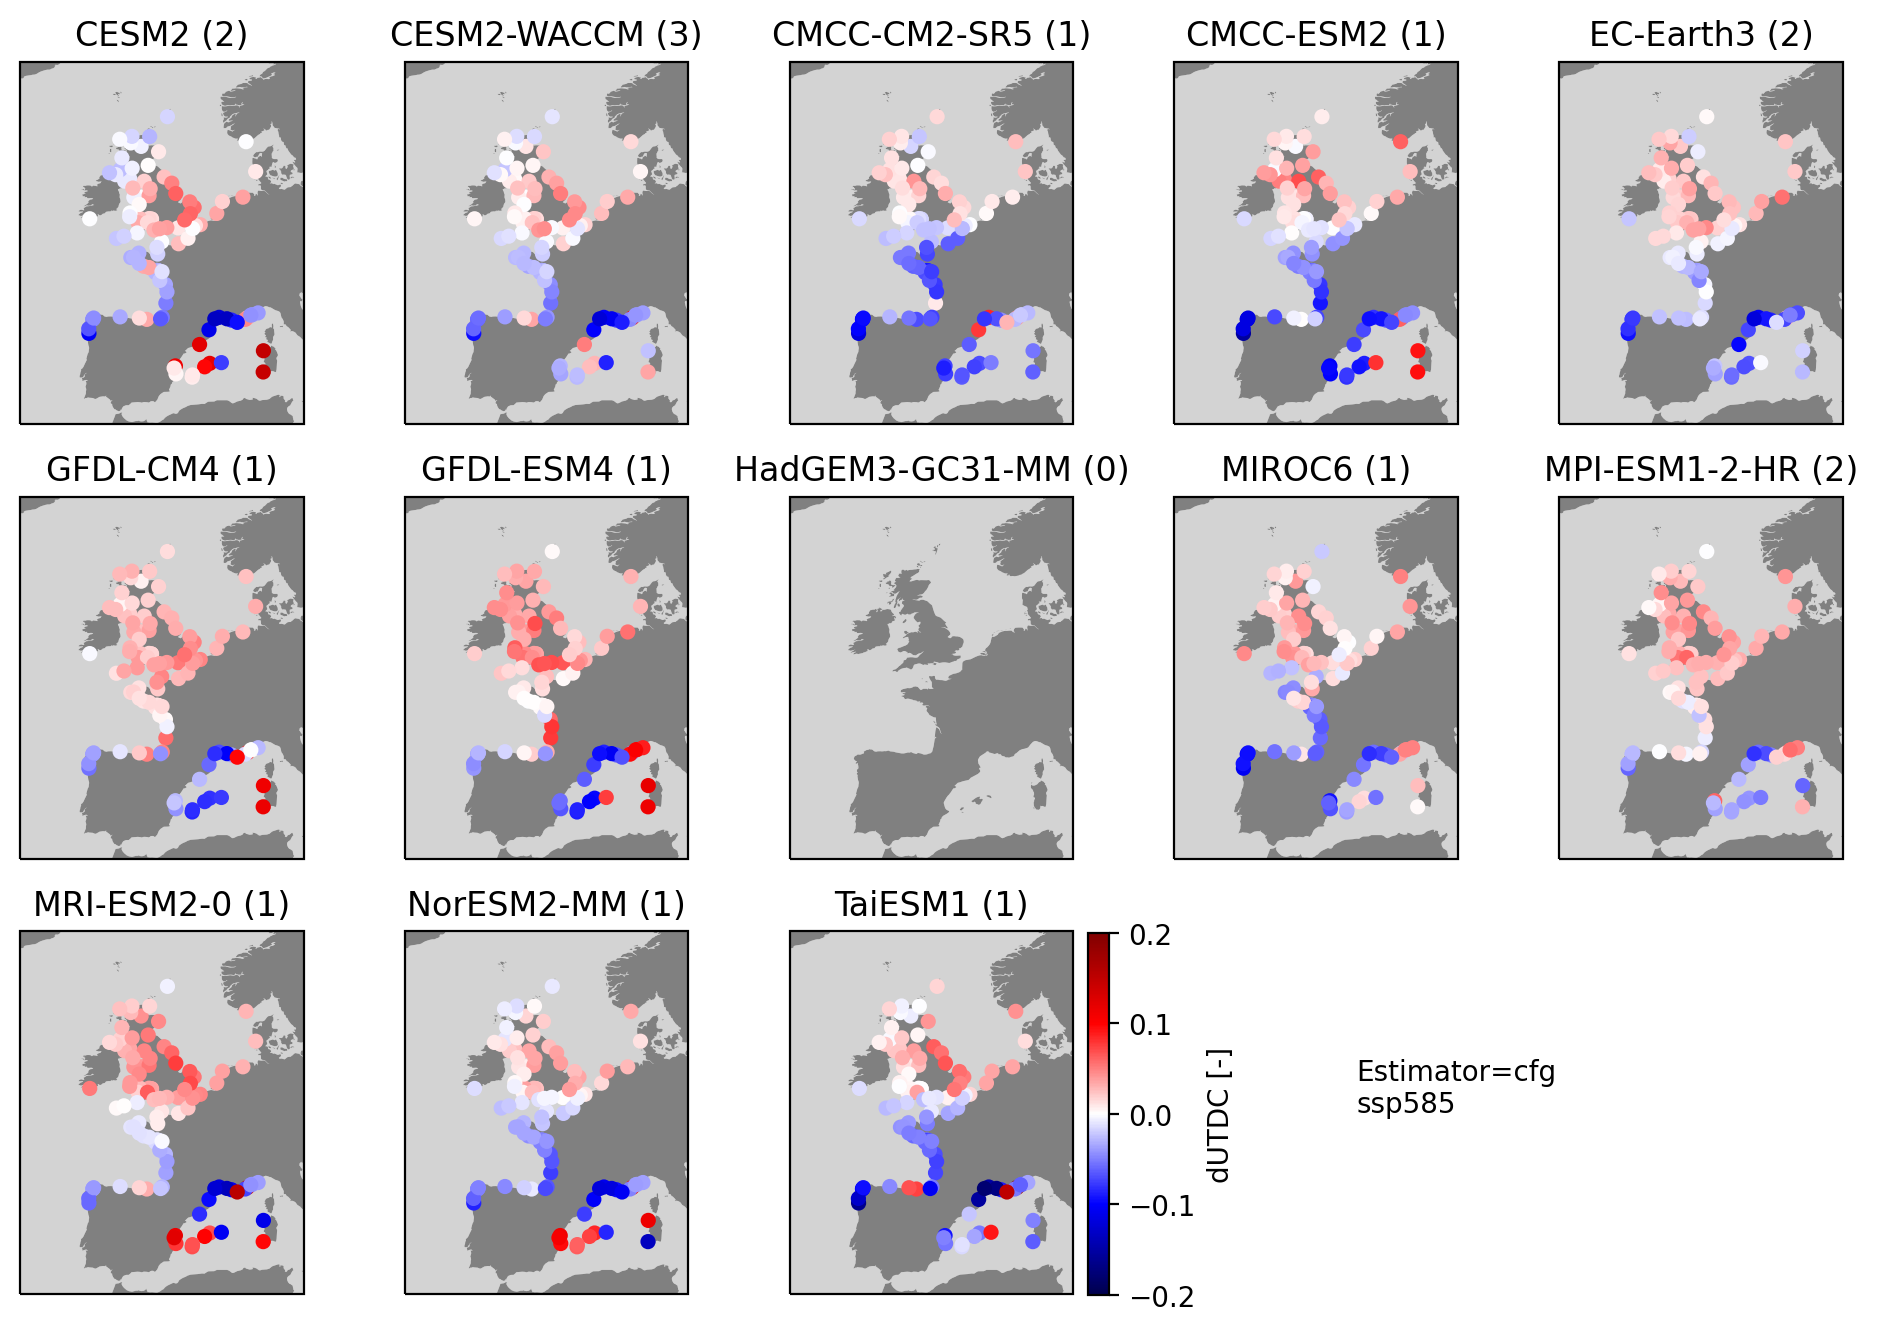

In [ ]:
for ssp in ssps:
    ssp_ds = ds_intersect.sel(ssp=ssp)

    ssp_ds_present = ssp_ds.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    fig=plt.figure(figsize=(12,8)) #generate figure  
    gs = fig.add_gridspec(3,5)

    for m,model in enumerate(ssp_ds.source_id.values):
        #1991-2020
        ax = plt.subplot(gs[np.unravel_index(m,(3,5))],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=ssp_ds_diff.utdc.sel(source_id=model).sel(statistic='coef',estimator='cfg').mean(dim='member_id'),cmap='seismic',vmin=-.2,vmax=.2,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
        n_members = np.isfinite(ssp_ds_present.utdc.sel(source_id=model).isel(tg=0,estimator=0,statistic=0)).sum(dim='member_id').values
        ax.set_title(model +' ('+str(n_members)+')')
        if m==len(ssp_ds.source_id.values)-1:
            cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
            cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='dUTDC [-]')
            ax.annotate('Estimator=cfg\n'+ssp,(2,.5),xycoords='axes fraction')

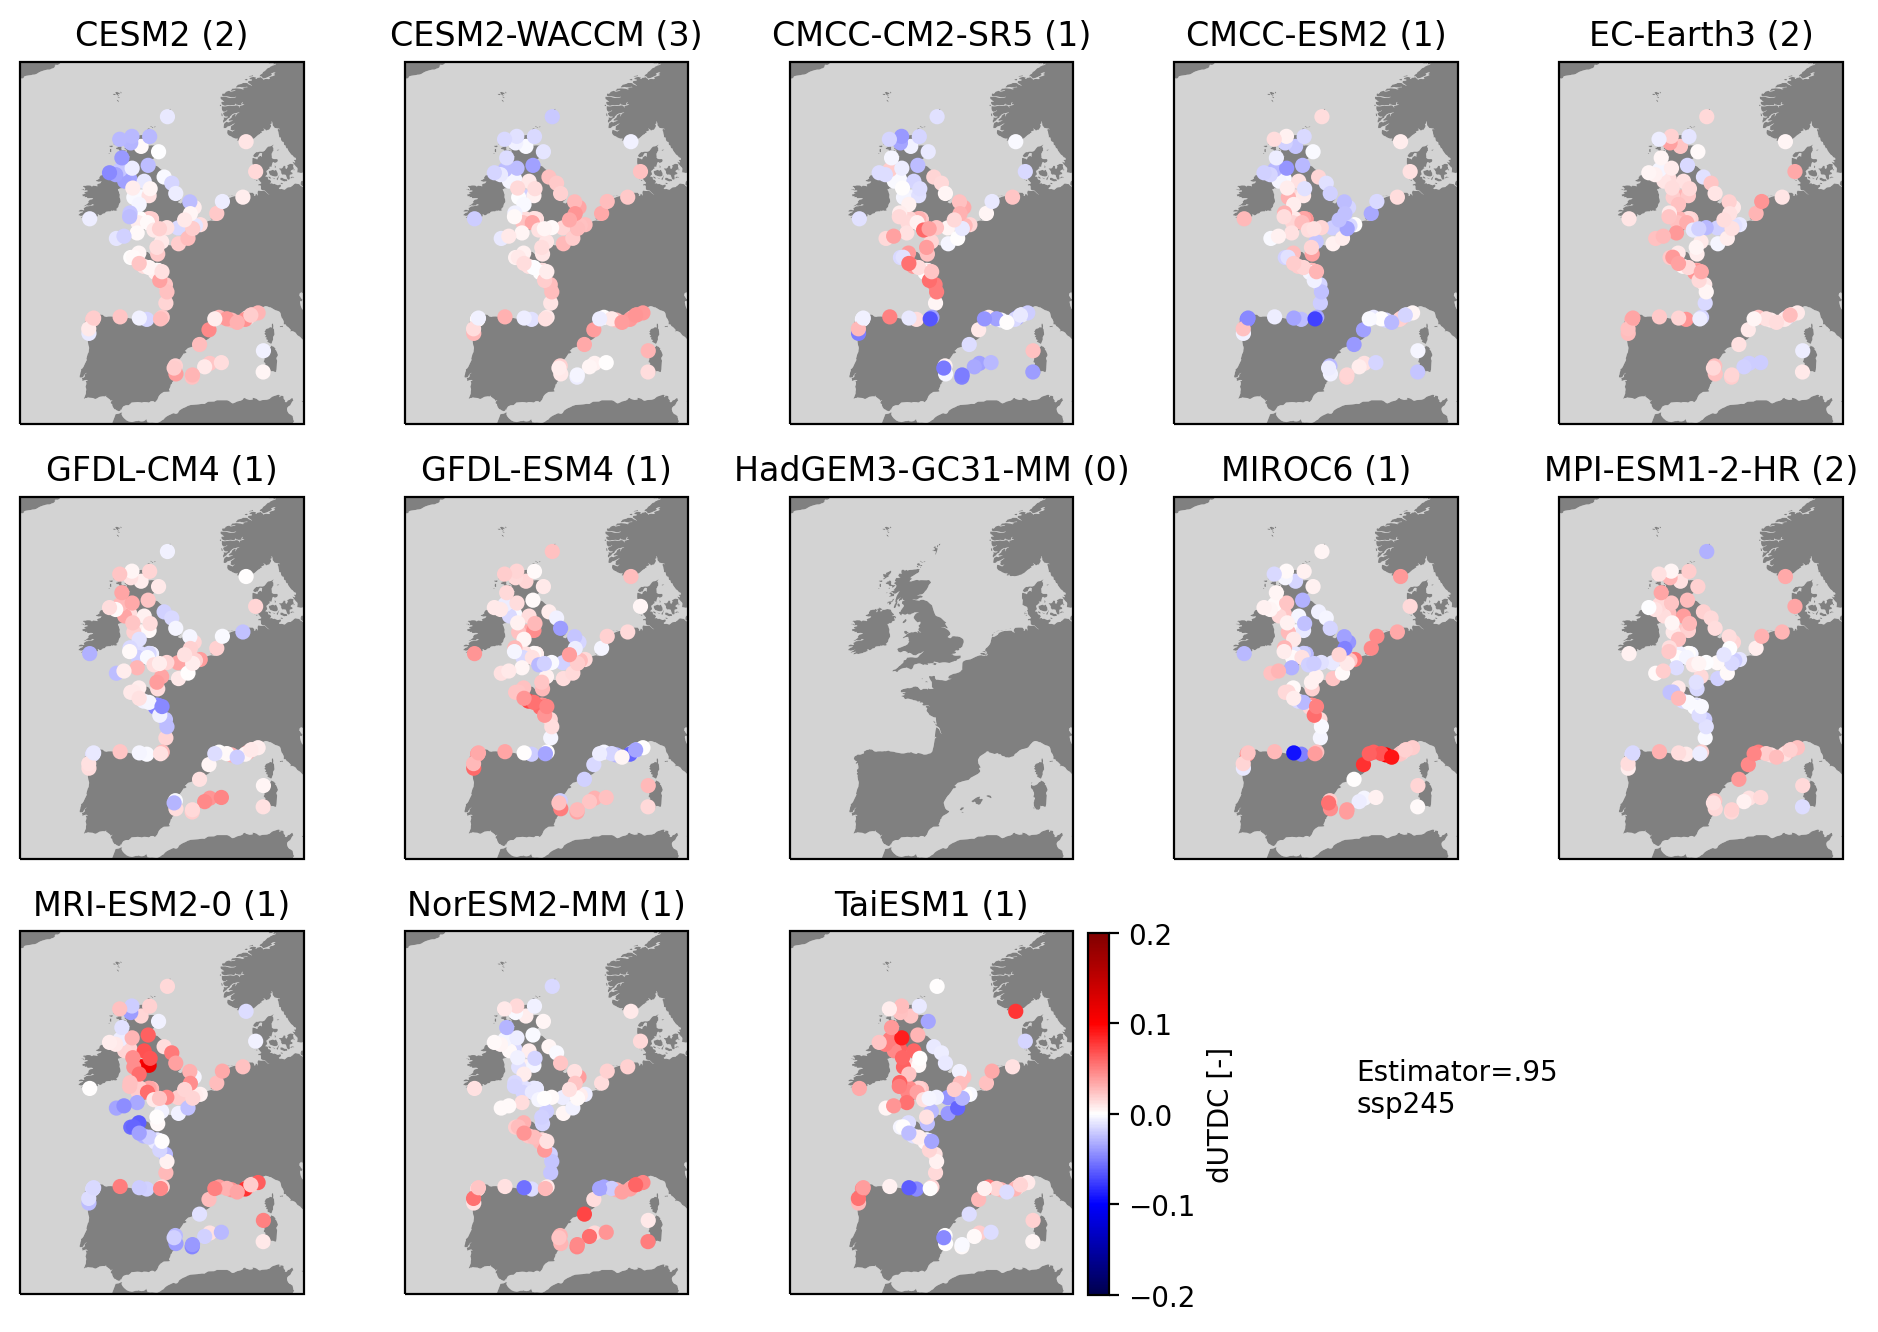

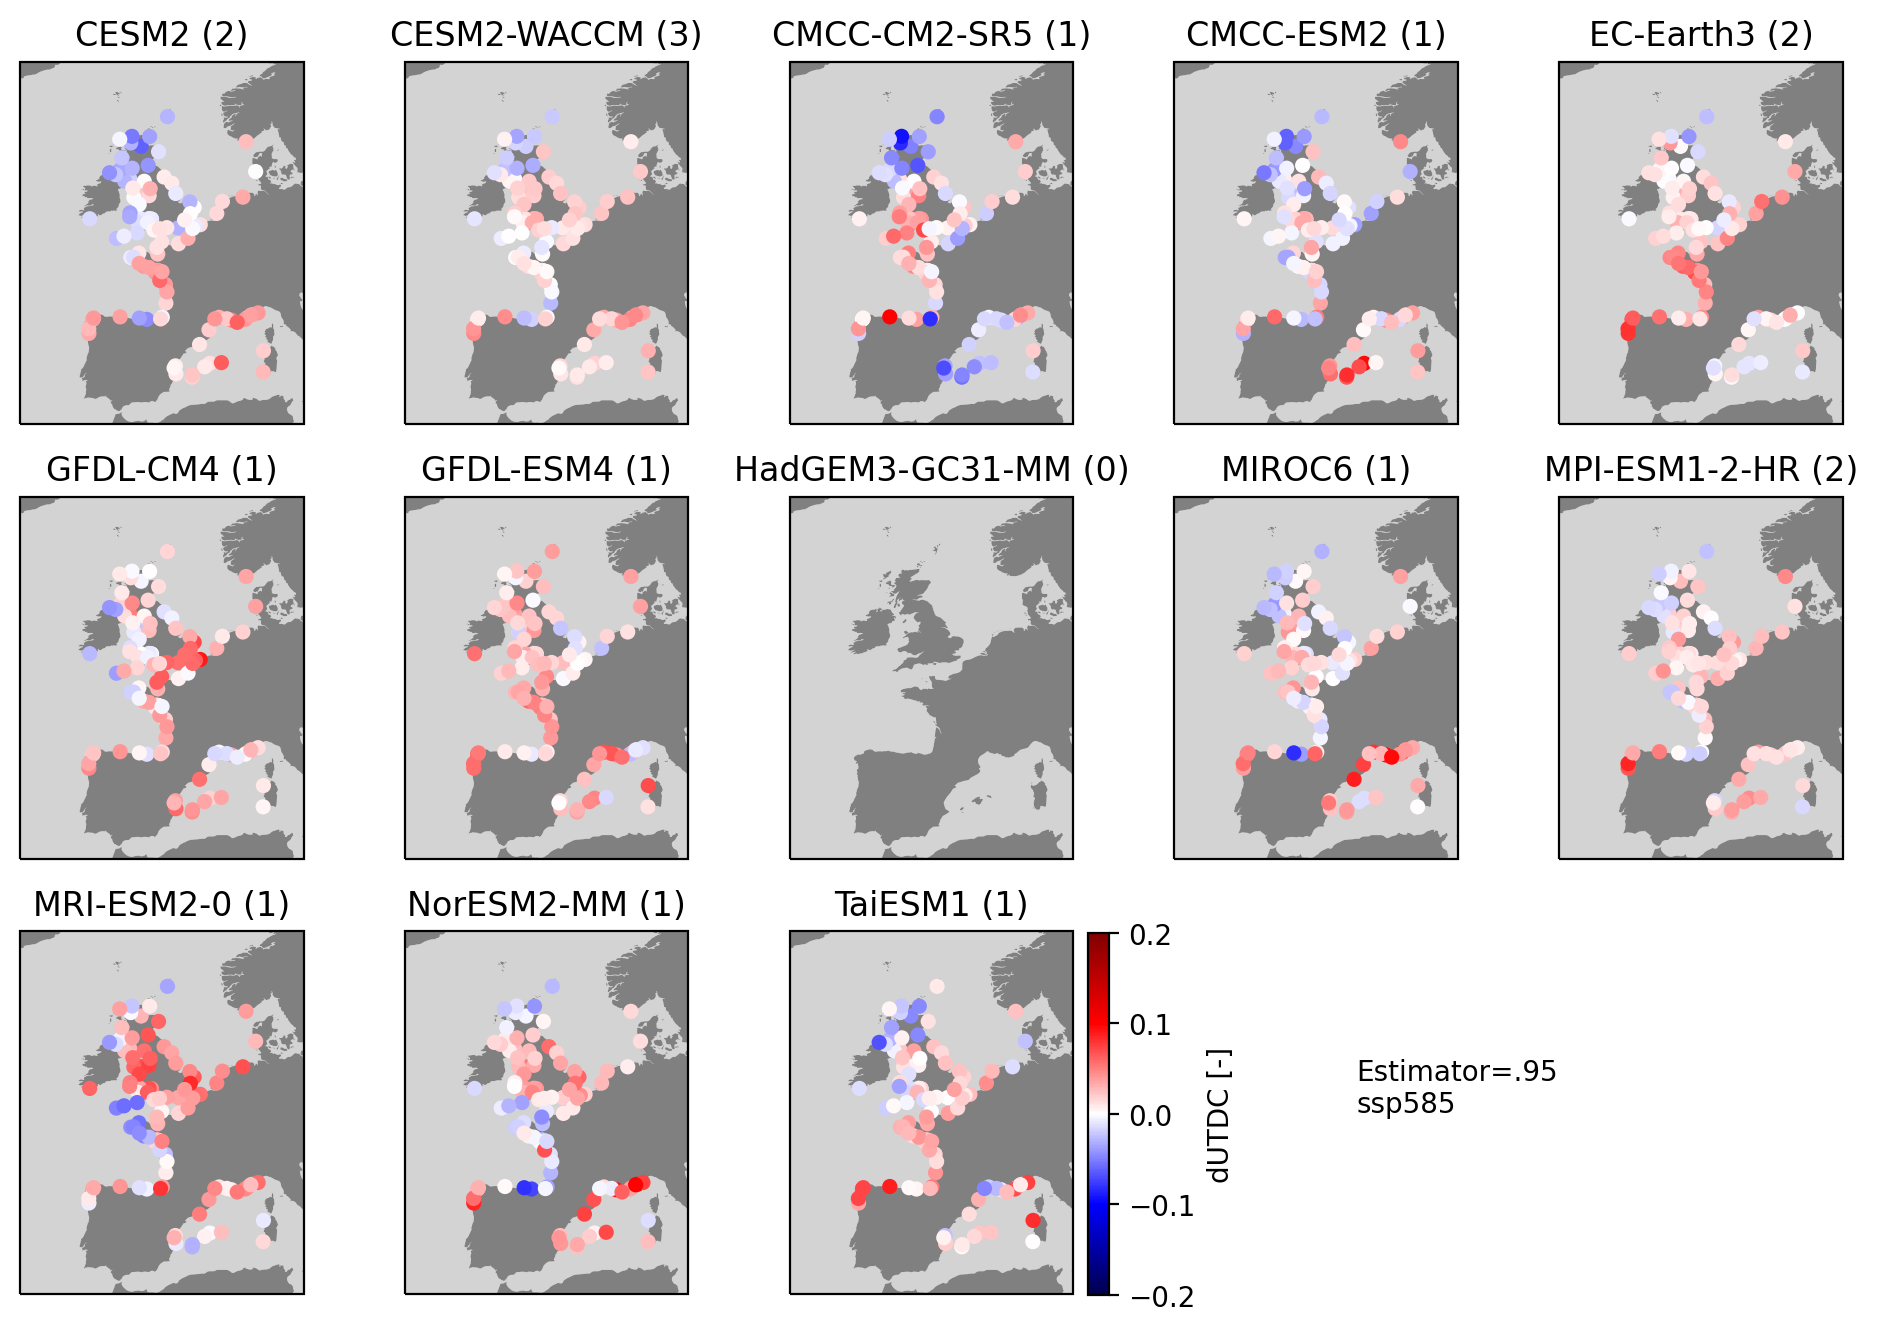

In [ ]:
for ssp in ssps:
    ssp_ds = ds_intersect.sel(ssp=ssp)

    ssp_ds_present = ssp_ds.sel(window=2005)
    ssp_ds_future = ssp_ds.sel(window=2085)
    ssp_ds_diff = ssp_ds_future - ssp_ds_present

    fig=plt.figure(figsize=(12,8)) #generate figure  
    gs = fig.add_gridspec(3,5)

    for m,model in enumerate(ssp_ds.source_id.values):
        #1991-2020
        ax = plt.subplot(gs[np.unravel_index(m,(3,5))],projection=ccrs.Robinson(central_longitude=0))

        ax.add_feature(cartopy.feature.OCEAN, zorder=0,facecolor='lightgrey')
        ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='grey')

        sc=ax.scatter(ssp_ds.lon,ssp_ds.lat,c=ssp_ds_diff.utdc.sel(source_id=model).sel(statistic='coef',estimator='.95').mean(dim='member_id'),cmap='seismic',vmin=-.2,vmax=.2,s=20,transform=ccrs.PlateCarree(),zorder=3)
        ax.set_extent([-15, 12, 35, 65], crs=ccrs.PlateCarree())
        n_members = np.isfinite(ssp_ds_present.utdc.sel(source_id=model).isel(tg=0,estimator=0,statistic=0)).sum(dim='member_id').values
        ax.set_title(model +' ('+str(n_members)+')')
        if m==len(ssp_ds.source_id.values)-1:
            cax=inset_axes(ax,width="100%", height="100%",bbox_to_anchor=(1.1, 0.035,.075,1),bbox_transform=ax.transAxes)
            cb=fig.colorbar(sc, cax=cax,orientation='vertical',label='dUTDC [-]')
            ax.annotate('Estimator=.95\n'+ssp,(2,.5),xycoords='axes fraction')